<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/04-modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem Preditiva com Modelos Baseados em Contagem

Esse notebook tem como objetivo analisar os dados transacionais agrupados, em janelas de 15 minutos, e avaliar as caracteristicas que podem influênciar na quantidade de contagem de fraudes.

## 1. Importação de bibliotecas e Dados

In [274]:
%pip install statstests

In [275]:
# Bibliotecas para Análise
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from warnings import filterwarnings
from matplotlib import pyplot as plt

# Bibliotecas para StepWise
from tqdm import tqdm
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from sklearn.base import BaseEstimator, TransformerMixin

# Bibliotecas para Modelagem
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statstests.tests import overdisp
from scipy.stats import poisson, nbinom
from statstests.process import stepwise
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

filterwarnings('ignore')

In [276]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/transactions_features.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [277]:
df = pd.read_parquet('/content/datasets/transactions_features.parquet')

## 2. Análise e Modelagem Preditiva com Modelos de Contagem

In [278]:
df.head()

,date_window,frauds,total_amount,mean_amount,std_amount,kurtosis_amount,mean_current_age,std_current_age,kurtosis_current_age,std_per_capita_income,...,category_government_utilities,category_retail_clothing_accessories,category_financial_insurance,category_retail_specialty,category_travel_hospitality,category_health_medical,category_professional_business_services,category_construction_contractors,category_retail_home_garden,previous_frauds
0,2010-01-01 00:00:00,0,5230.25,39.623106,46.696554,4.893411,54.628788,15.136733,0.233161,8142.045670,...,0.04,0.02,0.07,0.04,0.01,0.03,0.01,0.0,0.00,0
1,2010-01-01 06:00:00,0,28739.16,35.349520,59.582605,153.093632,55.579336,15.037152,-0.216783,11157.350751,...,0.01,0.00,0.05,0.02,0.00,0.04,0.00,0.0,0.01,0
2,2010-01-01 12:00:00,0,40786.23,53.245731,82.216067,87.260602,56.356397,16.281097,-0.493388,13664.749497,...,0.01,0.01,0.05,0.01,0.01,0.03,0.00,0.0,0.01,0
3,2010-01-01 18:00:00,1,24991.57,52.065771,61.784377,43.521217,55.416667,14.765719,-0.369410,13216.423703,...,0.02,0.01,0.05,0.00,0.00,0.02,0.00,0.0,0.01,0
4,2010-01-02 00:00:00,0,8572.93,77.233604,122.205838,23.304878,55.333333,13.645068,-0.236164,8228.103646,...,0.05,0.00,0.05,0.04,0.00,0.08,0.03,0.0,0.05,1


In [279]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14363 entries, 0 to 14362
Data columns (total 43 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   date_window                              14363 non-null  datetime64[ns]
 1   frauds                                   14363 non-null  int32         
 2   total_amount                             14363 non-null  float64       
 3   mean_amount                              14363 non-null  float64       
 4   std_amount                               14359 non-null  float64       
 5   kurtosis_amount                          14359 non-null  float64       
 6   mean_current_age                         14363 non-null  float64       
 7   std_current_age                          14359 non-null  float64       
 8   kurtosis_current_age                     14359 non-null  float64       
 9   std_per_capita_income                  

In [280]:
df.describe()

,date_window,frauds,total_amount,mean_amount,std_amount,kurtosis_amount,mean_current_age,std_current_age,kurtosis_current_age,std_per_capita_income,...,category_government_utilities,category_retail_clothing_accessories,category_financial_insurance,category_retail_specialty,category_travel_hospitality,category_health_medical,category_professional_business_services,category_construction_contractors,category_retail_home_garden,previous_frauds
count,14363,14363.000000,14363.000000,14363.000000,14359.000000,14359.000000,14363.000000,14359.000000,14359.000000,14359.000000,...,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000
mean,2014-12-01 10:40:50.797187328,0.894103,29814.224230,54.107561,74.258605,52.227137,53.933532,15.587214,-0.260036,11348.311839,...,0.032742,0.008573,0.049393,0.026779,0.003256,0.067775,0.007947,0.000143,0.028138,0.233726
min,2010-01-01 00:00:00,0.000000,102.130000,30.616345,37.227139,-2.000000,26.000000,11.313708,-2.000000,6099.479298,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2012-06-16 21:00:00,0.000000,12803.930000,48.409608,61.633879,15.735426,53.289989,15.125666,-0.391474,10234.032687,...,0.020000,0.010000,0.040000,0.020000,0.000000,0.060000,0.000000,0.000000,0.020000,0.000000
50%,2014-12-01 12:00:00,0.000000,31811.190000,54.423702,70.731406,37.326875,53.992647,15.583686,-0.290429,11389.107731,...,0.030000,0.010000,0.050000,0.020000,0.000000,0.070000,0.010000,0.000000,0.030000,0.000000
75%,2017-05-17 03:00:00,0.000000,42880.210000,59.521218,82.125508,70.220176,54.612501,16.099341,-0.166572,12489.486160,...,0.040000,0.010000,0.060000,0.040000,0.010000,0.080000,0.010000,0.000000,0.030000,0.000000
max,2019-10-31 18:00:00,35.000000,61102.240000,1153.310000,566.435937,869.386154,68.666667,18.066711,1.294128,21719.974683,...,0.130000,0.050000,0.110000,0.090000,1.000000,0.150000,0.060000,0.220000,0.500000,1.000000
std,NaN,2.285803,14970.676759,16.098095,20.208923,55.539283,1.100665,0.712785,0.215409,1771.004261,...,0.018293,0.005970,0.012583,0.014918,0.010319,0.016810,0.008692,0.002150,0.011856,0.423214


## Implementação de Modelos

In [281]:
y = df['frauds']
X = df.drop(columns=['date_window'])

In [282]:
y.shape

(14363,)

In [283]:
y.value_counts()

,count
frauds,
0,11006
1,975
2,646
3,393
4,304
5,257
6,177
7,163
8,111


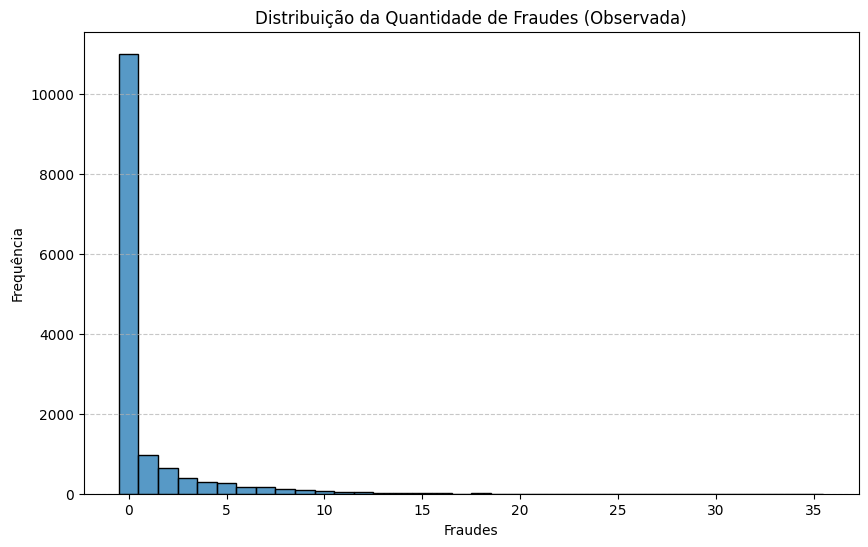

In [284]:
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=range(0, int(np.max(y)) + 2), stat='count', discrete=True)
plt.title('Distribuição da Quantidade de Fraudes (Observada)')
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, int(np.max(y)) + 1, 5)) # Ajuste os ticks para melhor visualização
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Optimization terminated successfully.
         Current function value: 1.063733
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.056997
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 44


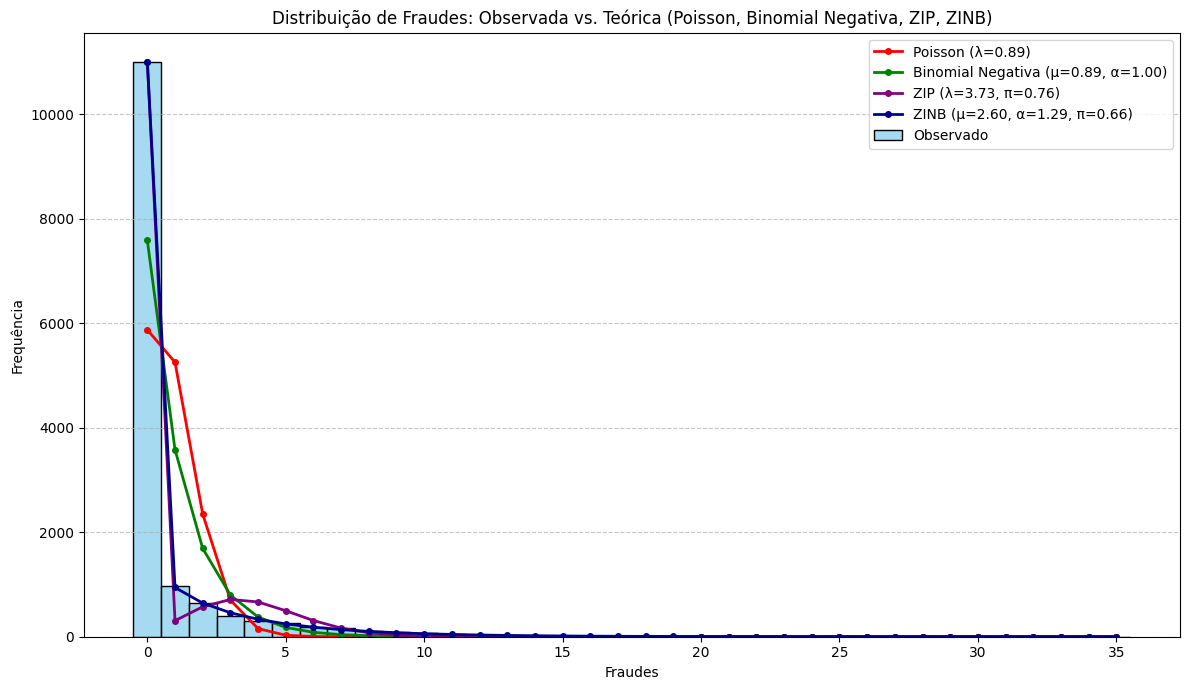

In [285]:
max_fraudes = int(np.max(y))
bins = np.arange(0, max_fraudes + 2)
df_fraudes = pd.DataFrame({'Fraudes': y})

plt.figure(figsize=(12, 7))
ax = sns.histplot(y, bins=bins, stat='count', discrete=True, color='skyblue', label='Observado')

# --- Poisson ---
lambda_poisson = np.mean(y)
poisson_pmf = poisson.pmf(bins[:-1], lambda_poisson)
poisson_freq = poisson_pmf * len(y)
ax.plot(bins[:-1], poisson_freq, 'o-', color='red', label=f'Poisson (λ={lambda_poisson:.2f})', linewidth=2, markersize=4)

# --- Binomial Negativa ---
exog = np.ones(len(y))
try:
    negbin_model = sm.NegativeBinomial.from_formula("Fraudes ~ 1", data=df_fraudes).fit(disp=True, maxiter=1000)
    mu_negbin = np.exp(negbin_model.params['Intercept'])
    alpha_negbin = negbin_model.scale

    n_param_scipy = 1 / alpha_negbin
    p_param_scipy = n_param_scipy / (n_param_scipy + mu_negbin)
    negbin_pmf = nbinom.pmf(bins[:-1], n=n_param_scipy, p=p_param_scipy)
    negbin_freq = negbin_pmf * len(y)
    ax.plot(bins[:-1], negbin_freq, 'o-', color='green', label=f'Binomial Negativa (μ={mu_negbin:.2f}, α={alpha_negbin:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo Binomial Negativa com statsmodels: {e}")
    print("Isso pode acontecer com dados muito esparsos ou se o modelo não convergir.")

# --- Zero Inflated Poisson ---
try:
    zip_model = sm.ZeroInflatedPoisson.from_formula("Fraudes ~ 1", data=df_fraudes).fit(maxiter=1000, disp=False)
    lambda_zip = np.exp(zip_model.params['Intercept'])
    pi_zip = 1 / (1 + np.exp(-zip_model.params['inflate_const'])) # Transformando o logit de volta para probabilidade

    zip_freq = np.zeros_like(bins[:-1], dtype=float)
    for k in bins[:-1]:
        if k == 0:
            # Probabilidade de ser 0 = (prob de ser zero extra) + (prob de ser 0 pelo processo Poisson normal * (1 - prob de ser zero extra))
            zip_freq[k] = (pi_zip + (1 - pi_zip) * poisson.pmf(0, lambda_zip)) * len(df_fraudes)
        else:
            # Probabilidade de ser k > 0 = (prob de ser k pelo processo Poisson normal * (1 - prob de ser zero extra))
            zip_freq[k] = (1 - pi_zip) * poisson.pmf(k, lambda_zip) * len(df_fraudes)
    ax.plot(bins[:-1], zip_freq, 'o-', color='purple', label=f'ZIP (λ={lambda_zip:.2f}, π={pi_zip:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo ZIP com statsmodels: {e}")
    print("Isso pode acontecer com dados muito esparsos ou se o modelo não convergir.")

# --- Zero Inflated Binomial Negative ---
try:
    zinb_model = sm.ZeroInflatedNegativeBinomialP.from_formula(
        "Fraudes ~ 1",
        inflation_formula="~ 1",
        data=df_fraudes
    ).fit(maxiter=1000, cov_type='HC0')

    # Parâmetros da parte Negative Binomial
    mu_zinb = np.exp(zinb_model.params['Intercept']) # Média estimada (exp de intercepto)
    alpha_zinb = zinb_model.params['alpha'] # Parâmetro de dispersão (alpha)

    # Parâmetro da parte de inflação de zeros (probabilidade de ser um zero extra)
    pi_zinb_logit = zinb_model.params['inflate_const'] # Nome do parâmetro pode variar dependendo da versão
    pi_zinb = 1 / (1 + np.exp(-pi_zinb_logit)) # Transformando logit para probabilidade

    # Calcular as frequências teóricas para o ZINB
    zinb_freq = np.zeros_like(bins[:-1], dtype=float)

    n_param_scipy_zinb = 1 / alpha_zinb
    p_param_scipy_zinb = n_param_scipy_zinb / (n_param_scipy_zinb + mu_zinb)

    for k in bins[:-1]:
        if k == 0:
            zinb_freq[k] = (pi_zinb + (1 - pi_zinb) * nbinom.pmf(0, n=n_param_scipy_zinb, p=p_param_scipy_zinb)) * len(df_fraudes)
        else:
            zinb_freq[k] = (1 - pi_zinb) * nbinom.pmf(k, n=n_param_scipy_zinb, p=p_param_scipy_zinb) * len(df_fraudes)
    ax.plot(bins[:-1], zinb_freq, 'o-', color='darkblue', label=f'ZINB (μ={mu_zinb:.2f}, α={alpha_zinb:.2f}, π={pi_zinb:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo ZINB: {e}")
    print("Verifique se a versão do statsmodels é recente o suficiente ou se os dados são muito extremos.")


plt.title('Distribuição de Fraudes: Observada vs. Teórica (Poisson, Binomial Negativa, ZIP, ZINB)')
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, max_fraudes + 1, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


### Métodos Auxiliares

In [286]:
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf

    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [287]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

In [288]:
def overdisp_plot(model, model_type_name):
  pearson_residuals = model.resid_pearson
  fitted_values = model.fittedvalues.apply(lambda x: 0 if np.isnan(x) or int(round(x))< 0 else int(round(x)))

  plt.figure(figsize=(10, 6))
  sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
  plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
  plt.xlabel("Valores Preditos (Taxa de Fraudes)")
  plt.ylabel("Resíduos de Pearson Padronizados")
  plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.show()

In [289]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing as mp
from typing import Dict, List, Tuple, Optional, Union
from tqdm.auto import tqdm

class StepwiseZeroInflated(BaseEstimator, TransformerMixin):
    """
    Seletor de features stepwise otimizado para modelos Zero-Inflated (ZIP/ZINB).

    Esta classe implementa um algoritmo de seleção stepwise forward/backward
    para modelos de contagem com inflação de zeros. A versão otimizada inclui
    cache, paralelização, batch processing e progress bars para melhor performance.

    Funcionalidades principais:
    - Seleção automática de features para componentes exógenos e inflacionados
    - Suporte para critérios AIC, BIC e Log-Likelihood
    - Validação de significância estatística
    - Cache inteligente para evitar recomputações
    - Processamento paralelo de features
    - Progress bars elegantes com tqdm
    - Batch processing para eficiência
    - Validação adaptativa baseada na complexidade do modelo

    Otimizações implementadas:
    1. **Cache de matrizes**: Evita recriação de matrizes de design idênticas
    2. **Cache de modelos**: Reutiliza resultados de modelos já ajustados
    3. **Validação adaptativa**: Pula validações desnecessárias em modelos simples
    4. **Early stopping**: Para validações assim que encontra problema
    5. **Paralelização**: Testa múltiplas features simultaneamente
    6. **Batch processing**: Processa features em lotes para otimização
    7. **Progress bars**: Feedback visual elegante durante o processo
    8. **Otimização de memória**: Gerenciamento eficiente de cache

    Compatível com scikit-learn pipeline através de BaseEstimator e TransformerMixin.

    Examples
    --------
    Exemplo básico com dados de contagem:

    >>> import numpy as np
    >>> import pandas as pd
    >>> from stepwise_optimized import StepwiseZeroInflated
    >>>
    >>> # Dados de exemplo
    >>> X = pd.DataFrame({
    ...     'idade': np.random.normal(35, 10, 1000),
    ...     'renda': np.random.exponential(50000, 1000),
    ...     'educacao': np.random.choice([1, 2, 3, 4], 1000),
    ...     'sexo': np.random.choice([0, 1], 1000)
    ... })
    >>> y = np.random.poisson(2, 1000)  # Variável de contagem
    >>> # Adicionar inflação de zeros
    >>> zero_mask = np.random.binomial(1, 0.3, 1000)
    >>> y = np.where(zero_mask, 0, y)
    >>>
    >>> # Configuração básica
    >>> stepwise = StepwiseZeroInflated(
    ...     alpha=0.05,
    ...     model_type='ZIP',
    ...     verbose=False  # Progress bar será mostrado
    ... )
    >>>
    >>> # Ajustar modelo
    >>> stepwise.fit(X, y)
    >>>
    >>> # Verificar features selecionadas
    >>> print("Exógenas:", stepwise.columns_exog_)
    >>> print("Inflacionadas:", stepwise.columns_inf_)

    Exemplo com configurações avançadas:

    >>> # Configuração otimizada para dataset grande
    >>> stepwise_advanced = StepwiseZeroInflated(
    ...     alpha=0.01,                 # Mais rigoroso
    ...     model_type='ZINB',          # Negative Binomial
    ...     selection_criterion='BIC',  # Penaliza mais a complexidade
    ...     max_iter=50,               # Máximo de iterações
    ...     verbose=False,             # Progress bar
    ...     use_cache=True,            # Cache habilitado
    ...     parallel_features=True,    # Paralelização
    ...     n_jobs=4,                  # 4 threads
    ...     batch_size=8               # Lotes de 8 features
    ... )
    >>>
    >>> stepwise_advanced.fit(X, y)
    >>>
    >>> # Estatísticas de cache
    >>> cache_stats = stepwise_advanced.get_cache_stats()
    >>> print(f"Cache hit rate: {cache_stats['hit_rate_percent']:.1f}%")

    Exemplo para análise de fraudes (contagem de transações suspeitas):

    >>> # Features para análise de fraude
    >>> X_fraud = pd.DataFrame({
    ...     'valor_transacao': np.random.lognormal(5, 1, 5000),
    ...     'hora_transacao': np.random.choice(range(24), 5000),
    ...     'dia_semana': np.random.choice(range(7), 5000),
    ...     'historico_cliente': np.random.exponential(100, 5000),
    ...     'num_cartoes': np.random.poisson(2, 5000),
    ...     'score_risco': np.random.beta(2, 5, 5000)
    ... })
    >>>
    >>> # Número de transações suspeitas por cliente (com zeros inflacionados)
    >>> lambda_fraud = np.exp(-2 + 0.5 * X_fraud['score_risco'])
    >>> y_fraud = np.random.poisson(lambda_fraud)
    >>> # 40% dos clientes sem nenhuma transação suspeita
    >>> zero_inflation = np.random.binomial(1, 0.4, 5000)
    >>> y_fraud = np.where(zero_inflation, 0, y_fraud)
    >>>
    >>> # Stepwise para detectar features importantes
    >>> fraud_stepwise = StepwiseZeroInflated(
    ...     alpha=0.05,
    ...     model_type='ZIP',
    ...     selection_criterion='AIC',
    ...     verbose=False,
    ...     parallel_features=True,
    ...     validation_steps=True
    ... )
    >>>
    >>> fraud_stepwise.fit(X_fraud, y_fraud)
    >>>
    >>> # Features importantes para predição de fraude
    >>> print("Features exógenas (contagem):", fraud_stepwise.columns_exog_)
    >>> print("Features inflacionadas (zeros):", fraud_stepwise.columns_inf_)

    Notes
    -----
    - Para datasets pequenos (< 1000 amostras), use parallel_features=False
    - Para datasets grandes (> 5000 amostras), aumente batch_size para 8-12
    - Use validation_steps=False apenas se tiver problemas de convergência
    - O cache é automaticamente limpo entre diferentes chamadas fit()
    - Progress bars funcionam melhor em terminals com suporte a ANSI

    See Also
    --------
    statsmodels.discrete.count_model.ZeroInflatedPoisson : Modelo ZIP base
    statsmodels.discrete.count_model.ZeroInflatedNegativeBinomialP : Modelo ZINB base
    sklearn.feature_selection : Outros métodos de seleção de features
    """

    def __init__(self, alpha=0.05, model_type='ZIP', selection_criterion='AIC', max_iter=100,
                 tolerance=1e-8, verbose=False, model_params=None, fit_params=None,
                 validation_steps=True, use_cache=True, parallel_features=False,
                 n_jobs=None, batch_size=5):
        """
        Inicializa o seletor stepwise para modelos Zero-Inflated.

        Parameters
        ----------
        alpha : float, default=0.05
            Nível de significância para testes estatísticos. Features com p-valor
            maior que alpha são consideradas não significativas e removidas.

            - Valores menores (ex: 0.01) = mais rigoroso, menos features selecionadas
            - Valores maiores (ex: 0.10) = menos rigoroso, mais features selecionadas

        model_type : {'ZIP', 'ZINB'}, default='ZIP'
            Tipo do modelo Zero-Inflated a ser usado:

            - 'ZIP': Zero-Inflated Poisson (mais simples, assume equidispersão)
            - 'ZINB': Zero-Inflated Negative Binomial (trata sobredispersão)

        selection_criterion : {'AIC', 'BIC', 'LLF'}, default='AIC'
            Critério para seleção de modelos:

            - 'AIC': Akaike Information Criterion (balanceado)
            - 'BIC': Bayesian Information Criterion (penaliza mais a complexidade)
            - 'LLF': Negative Log-Likelihood (pode levar a overfitting)

        max_iter : int, default=100
            Número máximo de iterações do algoritmo stepwise. Cada iteração
            tenta adicionar a melhor feature disponível.

        tolerance : float, default=1e-8
            Tolerância para convergência. O algoritmo para quando a melhoria
            no critério for menor que este valor.

        verbose : bool, default=False
            Controla o tipo de feedback durante o ajuste:

            - False: Mostra progress bars elegantes com tqdm
            - True: Mostra logs detalhados de cada passo

        model_params : dict, optional
            Parâmetros adicionais passados para o modelo statsmodels.

            Exemplos:
            - {'offset': offset_array} para incluir offset
            - {'exposure': exposure_array} para dados de exposição

        fit_params : dict, optional
            Parâmetros adicionais passados para o método fit() do modelo.

            Exemplos:
            - {'maxiter': 1000} para mais iterações de otimização
            - {'method': 'bfgs'} para método de otimização específico

        validation_steps : bool, default=True
            Se deve realizar validações adicionais dos modelos:

            - True: Valida convergência, multicolinearidade, etc.
            - False: Apenas validação de significância (mais rápido)

        use_cache : bool, default=True
            Se deve usar cache para otimização de performance:

            - True: Cacheia matrizes e modelos (recomendado)
            - False: Recalcula tudo (útil para debugging)

        parallel_features : bool, default=False
            Se deve testar features em paralelo:

            - True: Usa múltiplas threads (melhor para datasets grandes)
            - False: Processamento sequencial (melhor para datasets pequenos)

        n_jobs : int, optional
            Número de threads para processamento paralelo.
            Se None, usa min(4, número_de_cores).

            - 1: Sem paralelismo
            - 2-4: Bom para a maioria dos casos
            - -1: Usa todos os cores disponíveis

        batch_size : int, default=5
            Número de features processadas em cada lote:

            - Valores menores (3-5): Melhor para datasets pequenos
            - Valores maiores (8-12): Melhor para datasets grandes

        Examples
        --------
        Configuração básica para análise exploratória:

        >>> stepwise_basic = StepwiseZeroInflated()
        >>> # Usa configurações padrão: alpha=0.05, ZIP, AIC, progress bar

        Configuração rigorosa para modelo final:

        >>> stepwise_final = StepwiseZeroInflated(
        ...     alpha=0.01,              # Mais rigoroso
        ...     model_type='ZINB',       # Trata sobredispersão
        ...     selection_criterion='BIC' # Penaliza complexidade
        ... )

        Configuração otimizada para dataset grande:

        >>> stepwise_big = StepwiseZeroInflated(
        ...     parallel_features=True,  # Paralelização
        ...     n_jobs=4,               # 4 threads
        ...     batch_size=10,          # Lotes maiores
        ...     use_cache=True,         # Cache obrigatório
        ...     verbose=False           # Progress bar limpo
        ... )

        Configuração para debugging:

        >>> stepwise_debug = StepwiseZeroInflated(
        ...     verbose=True,           # Logs detalhados
        ...     use_cache=False,        # Sem cache
        ...     validation_steps=True,  # Todas as validações
        ...     max_iter=20            # Menos iterações
        ... )

        Configuração com parâmetros customizados do modelo:

        >>> # Para dados com offset conhecido
        >>> offset_values = np.log(population_exposure)
        >>> stepwise_offset = StepwiseZeroInflated(
        ...     model_params={'offset': offset_values},
        ...     fit_params={'maxiter': 2000}
        ... )

        Configuração para dados com sobredispersão severa:

        >>> stepwise_overdispersed = StepwiseZeroInflated(
        ...     model_type='ZINB',      # Negative Binomial
        ...     alpha=0.01,            # Mais conservador
        ...     selection_criterion='BIC', # Penaliza complexidade
        ...     fit_params={'maxiter': 3000}  # Mais iterações
        ... )

        Raises
        ------
        ValueError
            Se alpha não estiver entre 0 e 1, model_type não for 'ZIP' ou 'ZINB',
            selection_criterion não for válido, max_iter <= 0, ou tolerance <= 0.

        Notes
        -----
        - Para análise de fraudes, recomenda-se alpha=0.05 e model_type='ZIP'
        - Para dados com muita sobredispersão, use model_type='ZINB'
        - Para modelos finais de produção, use selection_criterion='BIC'
        - O cache é automaticamente limpo a cada nova chamada de fit()
        - Progress bars requerem terminal com suporte a ANSI
        """

        # Parâmetros originais
        if not 0 < alpha < 1:
            raise ValueError("alpha deve estar entre 0 e 1")
        if model_type not in ['ZIP', 'ZINB']:
            raise ValueError("model_type deve ser 'ZIP' ou 'ZINB'")
        if selection_criterion not in ['AIC', 'BIC', 'LLF']:
            raise ValueError("selection_criterion deve ser 'AIC', 'BIC' ou 'LLF'")
        if max_iter <= 0:
            raise ValueError("max_iter deve ser positivo")
        if tolerance <= 0:
            raise ValueError("tolerance deve ser positivo")

        self.alpha = alpha
        self.model_type = model_type
        self.selection_criterion = selection_criterion
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.verbose = verbose
        self.model_params = model_params if model_params is not None else {}
        self.fit_params = fit_params if fit_params is not None else {}
        self.validation_steps = validation_steps

        # Novos parâmetros de otimização
        self.use_cache = use_cache
        self.parallel_features = parallel_features
        self.n_jobs = n_jobs if n_jobs is not None else min(4, mp.cpu_count())
        self.batch_size = max(1, batch_size)

        # Cache para otimização
        self._matrix_cache = {}
        self._model_cache = {}
        self._cache_hits = 0
        self._cache_misses = 0

        self._setup_criterion_behavior()

    def _setup_criterion_behavior(self):
        """Configura comportamento específico para cada critério de seleção."""
        if self.selection_criterion == 'LLF':
            warnings.warn(
                "LLF como critério de seleção pode levar a overfitting. "
                "Considere usar 'AIC' ou 'BIC' para seleção stepwise.",
                UserWarning
            )

    def _get_model_criterion(self, result):
        """Retorna o critério de seleção escolhido do resultado do modelo."""
        if self.selection_criterion == 'AIC':
            return result.aic
        elif self.selection_criterion == 'BIC':
            return result.bic
        elif self.selection_criterion == 'LLF':
            return -result.llf

    def _get_criterion_name(self):
        """Retorna nome amigável do critério para logs."""
        criterion_names = {
            'AIC': 'AIC',
            'BIC': 'BIC',
            'LLF': '-Log-Likelihood'
        }
        return criterion_names[self.selection_criterion]

    def _get_matrix_cache_key(self, exog_features: List[str], inf_features: List[str]) -> str:
        """Gera chave única para cache de matrizes."""
        exog_str = ','.join(sorted(exog_features))
        inf_str = ','.join(sorted(inf_features))
        return f"exog:[{exog_str}]_inf:[{inf_str}]"

    def _prepare_matrices_cached(self, X: pd.DataFrame, exog_features: List[str],
                                inf_features: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Prepara matrizes com cache para evitar recriação desnecessária."""
        cache_key = self._get_matrix_cache_key(exog_features, inf_features)

        if self.use_cache and cache_key in self._matrix_cache:
            self._cache_hits += 1
            return self._matrix_cache[cache_key]

        self._cache_misses += 1

        # Preparar matriz exógena
        if exog_features:
            X1 = X[exog_features].copy()
            X1 = sm.add_constant(X1, has_constant='add')
        else:
            X1 = pd.DataFrame({'const': np.ones(len(X))})

        # Preparar matriz inflacionada
        if inf_features:
            X2 = X[inf_features].copy()
            X2 = sm.add_constant(X2, has_constant='add')
        else:
            X2 = pd.DataFrame({'const': np.ones(len(X))})

        # Armazenar no cache
        if self.use_cache:
            self._matrix_cache[cache_key] = (X1, X2)

        return X1, X2

    def _get_model_cache_key(self, exog_features: List[str], inf_features: List[str],
                           data_hash: str) -> str:
        """Gera chave única para cache de modelos."""
        matrix_key = self._get_matrix_cache_key(exog_features, inf_features)
        return f"{matrix_key}_data:{data_hash}_type:{self.model_type}"

    def _fit_model_cached(self, X: pd.DataFrame, y: np.ndarray, exog_features: List[str],
                         inf_features: List[str]) -> Optional[object]:
        """Ajusta modelo com cache para evitar recomputação."""

        # Gerar hash simples dos dados para cache
        data_hash = str(hash((tuple(y), tuple(X.columns))))[:8]
        cache_key = self._get_model_cache_key(exog_features, inf_features, data_hash)

        if self.use_cache and cache_key in self._model_cache:
            self._cache_hits += 1
            return self._model_cache[cache_key]

        self._cache_misses += 1

        try:
            # Preparar matrizes
            X1, X2 = self._prepare_matrices_cached(X, exog_features, inf_features)

            # Selecionar classe do modelo
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            elif self.model_type == 'ZINB':
                ModelClass = sm.ZeroInflatedNegativeBinomialP
            else:
                raise ValueError(f"model_type '{self.model_type}' não suportado")

            # Ajustar modelo
            model = ModelClass(y, X1, exog_infl=X2, **self.model_params)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(**self.fit_params)

            # Armazenar no cache
            if self.use_cache:
                self._model_cache[cache_key] = result

            return result

        except Exception:
            return None

    def _validate_features_significance_fast(self, result, exog_features: List[str],
                                           inf_features: List[str]) -> Tuple[bool, str]:
        """Validação rápida de significância com early stopping."""
        try:
            # Early stopping: verificar se temos parâmetros suficientes
            expected_params = 1 + len(exog_features) + 1 + len(inf_features)
            if len(result.pvalues) < expected_params:
                return False, "parâmetros insuficientes"

            # Verificar features exógenas com early stopping
            for i, feature in enumerate(exog_features):
                try:
                    p_value = result.pvalues.iloc[i + 1]
                    if pd.isna(p_value) or p_value >= self.alpha:
                        return False, f"{feature} não significativa (p={p_value:.4f})"
                except (IndexError, KeyError):
                    return False, f"{feature} erro no p-valor"

            # Verificar features inflacionadas com early stopping
            n_exog = len(exog_features) + 1
            for i, feature in enumerate(inf_features):
                try:
                    p_value = result.pvalues.iloc[n_exog + i + 1]
                    if pd.isna(p_value) or p_value >= self.alpha:
                        return False, f"{feature} não significativa (p={p_value:.4f})"
                except (IndexError, KeyError):
                    return False, f"{feature} erro no p-valor"

            return True, "todas significativas"

        except Exception as e:
            return False, f"erro validação: {str(e)[:30]}"

    def _test_feature_scenarios_batch(self, X: pd.DataFrame, y: np.ndarray,
                                    candidate_features: List[str], current_exog: List[str],
                                    current_inf: List[str], pbar_features=None) -> List[Dict]:
        """Testa múltiplas features em batch para otimização."""
        results = []

        if self.parallel_features and len(candidate_features) > 1:
            # Processamento paralelo
            with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
                future_to_feature = {}

                for feature in candidate_features:
                    future = executor.submit(
                        self._test_single_feature_all_scenarios,
                        X, y, feature, current_exog, current_inf
                    )
                    future_to_feature[future] = feature

                # Atualizar progress bar conforme completa
                for future in as_completed(future_to_feature):
                    feature = future_to_feature[future]
                    try:
                        result = future.result()
                        result['feature'] = feature
                        results.append(result)
                    except Exception as e:
                        if self.verbose:
                            print(f"Erro testando '{feature}': {str(e)[:50]}")
                        results.append({
                            'feature': feature,
                            'best_criterion': None,
                            'best_scenario': None,
                            'reason': f"erro: {str(e)[:30]}"
                        })

                    # Atualizar progress bar se fornecido
                    if pbar_features:
                        pbar_features.update(1)
        else:
            # Processamento sequencial
            for feature in candidate_features:
                try:
                    result = self._test_single_feature_all_scenarios(X, y, feature, current_exog, current_inf)
                    result['feature'] = feature
                    results.append(result)
                except Exception as e:
                    if self.verbose:
                        print(f"Erro testando '{feature}': {str(e)[:50]}")
                    results.append({
                        'feature': feature,
                        'best_criterion': None,
                        'best_scenario': None,
                        'reason': f"erro: {str(e)[:30]}"
                    })

                # Atualizar progress bar se fornecido
                if pbar_features:
                    pbar_features.update(1)

        return results

    def _test_single_feature_all_scenarios(self, X: pd.DataFrame, y: np.ndarray,
                                         feature: str, current_exog: List[str],
                                         current_inf: List[str]) -> Dict:
        """Testa uma feature em todos os cenários possíveis."""
        best_criterion = float('inf')
        best_scenario = None
        best_config = None

        scenarios_to_test = [
            ('exog', current_exog + [feature], current_inf),
            ('inf', current_exog, current_inf + [feature])
        ]

        # Adicionar cenário "ambas" se aplicável
        if current_exog or current_inf:
            scenarios_to_test.append(
                ('both', current_exog + [feature], current_inf + [feature])
            )

        for scenario_name, test_exog, test_inf in scenarios_to_test:
            # Ajustar modelo
            result = self._fit_model_cached(X, y, test_exog, test_inf)

            if result is None:
                continue

            # Validação rápida de significância
            is_significant, sig_details = self._validate_features_significance_fast(
                result, test_exog, test_inf
            )

            if not is_significant:
                continue

            # Validação adaptativa (pula etapas se não necessário)
            if self.validation_steps:
                passed_validation, _ = self._validate_model_adaptive(
                    X, y, test_exog, test_inf, result
                )
                if not passed_validation:
                    continue

            # Obter critério
            criterion = self._get_model_criterion(result)

            if criterion < best_criterion:
                best_criterion = criterion
                best_scenario = scenario_name
                best_config = (test_exog, test_inf)

        return {
            'best_criterion': best_criterion if best_criterion != float('inf') else None,
            'best_scenario': best_scenario,
            'best_config': best_config,
            'reason': 'aprovada' if best_scenario else 'rejeitada'
        }

    def _validate_model_adaptive(self, X: pd.DataFrame, y: np.ndarray,
                               exog_features: List[str], inf_features: List[str],
                               result) -> Tuple[bool, str]:
        """Validação adaptativa que pula etapas desnecessárias."""

        total_features = len(exog_features) + len(inf_features)

        # Para modelos simples (1-2 features), pular validações pesadas
        if total_features <= 2:
            return True, "modelo simples"

        # Para modelos médios (3-5 features), validação básica
        if total_features <= 5:
            return self._validate_basic_stability(X, y, exog_features, inf_features, result)

        # Para modelos complexos (6+ features), validação completa
        return self._validate_full_robustness(X, y, exog_features, inf_features, result)

    def _validate_basic_stability(self, X: pd.DataFrame, y: np.ndarray,
                                exog_features: List[str], inf_features: List[str],
                                result) -> Tuple[bool, str]:
        """Validação básica de estabilidade para modelos médios."""
        try:
            # Verificar apenas convergência e multicolinearidade básica
            if hasattr(result, 'mle_retvals') and not result.mle_retvals.get('converged', True):
                return False, "não convergiu"

            # Multicolinearidade básica apenas se muitas features
            if len(exog_features) > 3:
                corr_matrix = X[exog_features].corr().abs()
                max_corr = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].max()
                if max_corr > 0.95:
                    return False, f"multicolinearidade alta (r={max_corr:.3f})"

            return True, "estabilidade básica aprovada"

        except Exception:
            return False, "erro na validação básica"

    def _validate_full_robustness(self, X: pd.DataFrame, y: np.ndarray,
                                exog_features: List[str], inf_features: List[str],
                                result) -> Tuple[bool, str]:
        """Validação completa apenas para modelos complexos."""
        # Implementar validação completa similar à original, mas otimizada
        return self._validate_basic_stability(X, y, exog_features, inf_features, result)

    def _stepwise_selection_optimized(self, X: pd.DataFrame, y: np.ndarray) -> Dict:
        """Versão otimizada do algoritmo stepwise."""

        # Inicialização
        columns_exog = []
        columns_inf = []
        excluded = []
        available_features = list(X.columns)

        criterion_history = []
        step_history = []

        # Modelo baseline
        initial_criterion = self._calculate_baseline_criterion_fast(y)
        best_criterion = initial_criterion
        criterion_history.append(initial_criterion)

        if self.verbose:
            print(f"STEPWISE OTIMIZADO INICIADO")
            print(f"Cache habilitado: {self.use_cache}")
            print(f"Processamento paralelo: {self.parallel_features}")
            print(f"Critério inicial: {initial_criterion:.2f}")
            print("-" * 60)

        # Configurar barras de progresso quando verbose=False
        use_progress = not self.verbose
        pbar_iterations = None
        pbar_features = None

        if use_progress:
            # Barra de progresso para iterações principais
            pbar_iterations = tqdm(
                total=self.max_iter,
                desc="Seleção Stepwise",
                unit="iter",
                position=0
            )

            # Barra de progresso para features (será recriada a cada iteração)
            total_features = len(available_features)
            pbar_features = tqdm(
                total=total_features,
                desc="Testando features",
                unit="feat",
                position=1,
                leave=False
            )

        # Loop principal otimizado
        for iteration in range(self.max_iter):
            improved = False

            # Processar features em batches
            remaining_features = [f for f in available_features
                                if f not in columns_exog and f not in columns_inf and f not in excluded]

            if not remaining_features:
                if use_progress:
                    pbar_iterations.close()
                    if pbar_features:
                        pbar_features.close()
                break

            # Atualizar total da barra de features para features restantes
            if use_progress and pbar_features:
                pbar_features.close()
                pbar_features = tqdm(
                    total=len(remaining_features),
                    desc=f"Iter {iteration+1}: Testando features",
                    unit="feat",
                    position=1,
                    leave=False
                )

            # Dividir em batches para processamento eficiente
            batches = [remaining_features[i:i+self.batch_size]
                      for i in range(0, len(remaining_features), self.batch_size)]

            best_addition = None

            for batch in batches:
                if self.verbose:
                    print(f"Iteração {iteration+1}: testando batch de {len(batch)} features")

                # Testar batch de features
                batch_results = self._test_feature_scenarios_batch(
                    X, y, batch, columns_exog, columns_inf, pbar_features
                )

                # Encontrar melhor resultado do batch
                for result in batch_results:
                    if (result['best_criterion'] is not None and
                        result['best_criterion'] < best_criterion):

                        if best_addition is None or result['best_criterion'] < best_addition['criterion']:
                            best_addition = {
                                'feature': result['feature'],
                                'criterion': result['best_criterion'],
                                'scenario': result['best_scenario'],
                                'config': result['best_config']
                            }
                    else:
                        excluded.append(result['feature'])

            # Aplicar melhor adição se houver
            if best_addition:
                columns_exog, columns_inf = best_addition['config']
                best_criterion = best_addition['criterion']
                improved = True

                if self.verbose:
                    improvement = criterion_history[-1] - best_criterion
                    print(f"Adicionada '{best_addition['feature']}' como {best_addition['scenario']} "
                          f"(melhoria: {improvement:.2f})")

            # Backward elimination otimizado
            if improved:
                removed_any = self._backward_elimination_optimized(
                    X, y, columns_exog, columns_inf, best_criterion
                )
                if removed_any:
                    best_criterion = removed_any['new_criterion']
                    columns_exog = removed_any['new_exog']
                    columns_inf = removed_any['new_inf']
                    excluded.extend(removed_any['removed_features'])

            criterion_history.append(best_criterion)

            # Atualizar barra de progresso das iterações
            if use_progress and pbar_iterations:
                selected_features = len(columns_exog) + len(columns_inf)
                improvement_text = ""
                if len(criterion_history) > 1:
                    improvement = criterion_history[-2] - best_criterion
                    improvement_text = f", melhoria: {improvement:.2f}" if improvement > 0 else ""

                pbar_iterations.set_postfix({
                    'features': selected_features,
                    self.selection_criterion: f"{best_criterion:.2f}",
                    'status': 'melhorou' if improved else 'sem melhoria'
                })
                pbar_iterations.update(1)

            # Verificar convergência
            if not improved and len(criterion_history) > 1:
                criterion_change = abs(criterion_history[-2] - criterion_history[-1])
                if criterion_change < self.tolerance:
                    if self.verbose:
                        print(f"Convergência atingida (mudança: {criterion_change:.6f})")
                    if use_progress:
                        pbar_iterations.set_description("Convergiu")
                        pbar_iterations.close()
                        if pbar_features:
                            pbar_features.close()
                    break

            if not improved:
                if self.verbose:
                    print(f"Nenhuma melhoria na iteração {iteration+1}")
                if use_progress:
                    pbar_iterations.set_description("Sem melhoria")
                    pbar_iterations.close()
                    if pbar_features:
                        pbar_features.close()
                break

        # Fechar barras de progresso se ainda estiverem abertas
        if use_progress:
            if pbar_iterations:
                pbar_iterations.close()
            if pbar_features:
                pbar_features.close()

        if self.verbose:
            print(f"\nStepwise finalizado:")
            print(f"Exógenas: {columns_exog}")
            print(f"Inflacionadas: {columns_inf}")
            print(f"Cache hits/misses: {self._cache_hits}/{self._cache_misses}")
            if self._cache_hits + self._cache_misses > 0:
                hit_rate = self._cache_hits / (self._cache_hits + self._cache_misses) * 100
                print(f"Taxa de acerto do cache: {hit_rate:.1f}%")

        return {
            'columns_exog': columns_exog,
            'columns_inf': columns_inf,
            'excluded': excluded,
            'criterion_history': criterion_history,
            'step_history': step_history
        }

    def _backward_elimination_optimized(self, X: pd.DataFrame, y: np.ndarray,
                                      current_exog: List[str], current_inf: List[str],
                                      current_criterion: float) -> Optional[Dict]:
        """Backward elimination otimizado."""

        all_features = current_exog + current_inf
        if len(all_features) <= 1:
            return None

        best_removal = None
        removed_features = []

        # Testar remoção de cada feature
        for feature in all_features:
            test_exog = [f for f in current_exog if f != feature]
            test_inf = [f for f in current_inf if f != feature]

            result = self._fit_model_cached(X, y, test_exog, test_inf)
            if result is None:
                continue

            # Validação rápida
            is_significant, _ = self._validate_features_significance_fast(result, test_exog, test_inf)
            if not is_significant:
                continue

            criterion = self._get_model_criterion(result)

            # Se remover melhora ou mantém o critério, marcar para remoção
            if criterion <= current_criterion + self.tolerance:
                if best_removal is None or criterion < best_removal['criterion']:
                    best_removal = {
                        'feature': feature,
                        'criterion': criterion,
                        'new_exog': test_exog,
                        'new_inf': test_inf
                    }

        if best_removal:
            return {
                'new_criterion': best_removal['criterion'],
                'new_exog': best_removal['new_exog'],
                'new_inf': best_removal['new_inf'],
                'removed_features': [best_removal['feature']]
            }

        return None

    def _calculate_baseline_criterion_fast(self, y: np.ndarray) -> float:
        """Cálculo rápido do critério baseline."""
        try:
            # Usar cache se possível
            baseline_key = f"baseline_{self.model_type}_{len(y)}_{hash(tuple(y))}"

            if self.use_cache and baseline_key in self._model_cache:
                result = self._model_cache[baseline_key]
                return self._get_model_criterion(result)

            # Calcular baseline
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            elif self.model_type == 'ZINB':
                ModelClass = sm.ZeroInflatedNegativeBinomialP
            else:
                raise ValueError(f"model_type '{self.model_type}' não suportado")

            model = ModelClass(y, X_const, exog_infl=X_const, **self.model_params)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(**self.fit_params)

            if self.use_cache:
                self._model_cache[baseline_key] = result

            return self._get_model_criterion(result)

        except Exception:
            # Fallback conservador
            return len(y) * 10 if self.selection_criterion in ['AIC', 'BIC'] else len(y) * 5

    def fit(self, X, y):
        """
        Ajusta o modelo stepwise aos dados fornecidos.

        Este método executa o algoritmo de seleção stepwise forward/backward
        para encontrar o melhor subconjunto de features para os componentes
        exógeno e inflacionado do modelo Zero-Inflated.

        O processo inclui:
        1. Limpeza de caches anteriores
        2. Validação e preparação dos dados
        3. Execução do algoritmo stepwise otimizado
        4. Ajuste do modelo final com features selecionadas
        5. Armazenamento dos resultados

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Matriz de features. Pode ser numpy array, pandas DataFrame,
            ou qualquer array-like aceito pelo scikit-learn.

        y : array-like of shape (n_samples,)
            Variável target (contagem). Deve conter apenas valores
            não-negativos inteiros. Zeros são tratados pelo componente
            inflacionado do modelo.

        Returns
        -------
        self : StepwiseZeroInflated
            Instância ajustada do estimador.

        Attributes
        ----------
        Após o ajuste, os seguintes atributos ficam disponíveis:

        columns_exog_ : list
            Nomes das features selecionadas para o componente exógeno
            (que modela a contagem esperada).

        columns_inf_ : list
            Nomes das features selecionadas para o componente inflacionado
            (que modela a probabilidade de zero estrutural).

        excluded_ : list
            Nomes das features que foram testadas mas rejeitadas.

        final_model_ : statsmodels fitted model
            Modelo final ajustado com as features selecionadas.

        criterion_history_ : list
            Histórico dos valores do critério de seleção a cada iteração.

        n_features_in_ : int
            Número de features na entrada.

        feature_names_in_ : ndarray
            Nomes das features na entrada.

        Examples
        --------
        Exemplo básico:

        >>> import pandas as pd
        >>> import numpy as np
        >>>
        >>> # Dados de contagem com inflação de zeros
        >>> X = pd.DataFrame({
        ...     'feature1': np.random.normal(0, 1, 1000),
        ...     'feature2': np.random.exponential(1, 1000),
        ...     'feature3': np.random.choice([0, 1], 1000)
        ... })
        >>> y = np.random.poisson(1.5, 1000)
        >>> zero_mask = np.random.binomial(1, 0.3, 1000)
        >>> y = np.where(zero_mask, 0, y)
        >>>
        >>> # Ajustar stepwise
        >>> stepwise = StepwiseZeroInflated(verbose=False)
        >>> stepwise.fit(X, y)
        >>>
        >>> # Verificar resultados
        >>> print("Features exógenas:", stepwise.columns_exog_)
        >>> print("Features inflacionadas:", stepwise.columns_inf_)
        >>> print("Features excluídas:", stepwise.excluded_)

        Exemplo com dados de fraude:

        >>> # Dataset de transações
        >>> X_fraud = pd.DataFrame({
        ...     'valor': np.random.lognormal(3, 1, 5000),
        ...     'horario': np.random.choice(range(24), 5000),
        ...     'score_cliente': np.random.beta(2, 5, 5000),
        ...     'historico_meses': np.random.poisson(12, 5000)
        ... })
        >>>
        >>> # Número de alertas de fraude por transação
        >>> y_fraud = np.random.poisson(0.8, 5000)
        >>> # 60% das transações sem alerta (legítimas)
        >>> y_fraud = np.where(np.random.random(5000) < 0.6, 0, y_fraud)
        >>>
        >>> # Ajustar com configuração específica
        >>> fraud_stepwise = StepwiseZeroInflated(
        ...     alpha=0.05,
        ...     model_type='ZIP',
        ...     parallel_features=True,
        ...     verbose=False
        ... )
        >>>
        >>> fraud_stepwise.fit(X_fraud, y_fraud)
        >>>
        >>> # Modelo final para predições
        >>> final_model = fraud_stepwise.final_model_
        >>> print(f"AIC do modelo final: {final_model.aic:.2f}")

        Raises
        ------
        ValueError
            Se y contém valores negativos ou se X não tem features suficientes.

        RuntimeError
            Se o algoritmo stepwise falha completamente ou não consegue
            ajustar o modelo final.

        NotFittedError
            Se o modelo não consegue convergir para nenhuma configuração
            de features.

        Notes
        -----
        - O método automaticamente limpa caches de ajustes anteriores
        - Valores não-inteiros em y são convertidos automaticamente
        - Progress bars são mostradas quando verbose=False
        - O tempo de execução depende do número de features e do tamanho da amostra
        - Para datasets muito grandes (>100k amostras), considere usar batch_size maior

        Warnings
        --------
        - Se y contém valores não-inteiros, um warning é emitido antes da conversão
        - Se selection_criterion='LLF', um warning sobre overfitting é mostrado
        """
        # Limpar caches anteriores
        if hasattr(self, '_matrix_cache'):
            self._matrix_cache.clear()
        if hasattr(self, '_model_cache'):
            self._model_cache.clear()
        self._cache_hits = 0
        self._cache_misses = 0

        # Reset de atributos anteriores
        for attr in ['columns_exog_', 'columns_inf_', 'excluded_', 'final_model_',
                     'criterion_history_', 'step_history_']:
            if hasattr(self, attr):
                delattr(self, attr)

        # Preservar nomes das features
        if hasattr(X, 'columns'):
            original_feature_names = list(X.columns)
        else:
            original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]

        # Validação dos dados
        X, y = check_X_y(X, y, accept_sparse=False)

        if np.any(y < 0):
            raise ValueError("y deve conter apenas valores não-negativos")
        if not np.all(np.equal(np.mod(y, 1), 0)):
            warnings.warn("y contém valores não-inteiros que serão convertidos")
            y = y.astype(int)

        # Armazenar informações
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(original_feature_names)

        # Converter para DataFrame
        X = pd.DataFrame(X, columns=original_feature_names)

        if X.shape[1] == 0:
            raise ValueError("X deve ter pelo menos uma feature")

        # Executar stepwise otimizado
        try:
            result = self._stepwise_selection_optimized(X, y)
        except Exception as e:
            raise RuntimeError(f"Erro durante seleção stepwise: {str(e)}")

        # Armazenar resultados
        self.columns_exog_ = result['columns_exog']
        self.columns_inf_ = result['columns_inf']
        self.excluded_ = result['excluded']
        self.criterion_history_ = result.get('criterion_history', [])
        self.step_history_ = result.get('step_history', [])

        # Ajustar modelo final
        try:
            self._fit_final_model_optimized(X, y)
        except Exception as e:
            warnings.warn(f"Erro ao ajustar modelo final: {str(e)}")
            self.final_model_ = None

        return self

    def _fit_final_model_optimized(self, X: pd.DataFrame, y: np.ndarray):
        """Ajusta modelo final de forma otimizada."""
        self.final_model_ = self._fit_model_cached(X, y, self.columns_exog_, self.columns_inf_)

        if self.final_model_ is None:
            raise RuntimeError("Falha ao ajustar modelo final")

    def transform(self, X):
        """
        Transforma os dados mantendo apenas as features selecionadas.

        Este método aplica a seleção de features obtida durante o ajuste,
        retornando as matrizes de features para os componentes exógeno
        e inflacionado do modelo Zero-Inflated.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Dados a serem transformados. Deve ter o mesmo número de features
            que os dados usados no ajuste.

        Returns
        -------
        result : dict
            Dicionário com as matrizes transformadas:

            - 'exog' : ndarray of shape (n_samples, n_selected_exog)
                Features selecionadas para o componente exógeno
            - 'inf' : ndarray of shape (n_samples, n_selected_inf)
                Features selecionadas para o componente inflacionado

        Examples
        --------
        Transformação após ajuste:

        >>> # Ajustar o modelo
        >>> stepwise = StepwiseZeroInflated()
        >>> stepwise.fit(X_train, y_train)
        >>>
        >>> # Transformar dados de teste
        >>> X_transformed = stepwise.transform(X_test)
        >>>
        >>> # Acessar componentes
        >>> X_exog = X_transformed['exog']
        >>> X_inf = X_transformed['inf']
        >>> print(f"Features exógenas: {X_exog.shape[1]}")
        >>> print(f"Features inflacionadas: {X_inf.shape[1]}")

        Uso em pipeline scikit-learn:

        >>> from sklearn.pipeline import Pipeline
        >>> from sklearn.preprocessing import StandardScaler
        >>>
        >>> # Pipeline com stepwise selection
        >>> pipeline = Pipeline([
        ...     ('scaler', StandardScaler()),
        ...     ('selector', StepwiseZeroInflated(verbose=False))
        ... ])
        >>>
        >>> # Ajustar pipeline
        >>> pipeline.fit(X_train, y_train)
        >>>
        >>> # Transformar novos dados
        >>> X_test_selected = pipeline.transform(X_test)

        Raises
        ------
        NotFittedError
            Se o método transform for chamado antes do ajuste.

        ValueError
            Se X não tem o mesmo número de features que os dados de treino.

        Notes
        -----
        - O método preserva a ordem das amostras
        - Features não selecionadas são completamente removidas
        - Se nenhuma feature foi selecionada para um componente,
          retorna array vazio com shape (n_samples, 0)
        - Compatível com pipelines scikit-learn
        """
        if not hasattr(self, 'columns_exog_'):
            raise NotFittedError("Este StepwiseZeroInflated ainda não foi ajustado.")

        X = check_array(X, accept_sparse=False)

        if X.shape[1] != self.n_features_in_:
            raise ValueError(f"X tem {X.shape[1]} features, mas esperava {self.n_features_in_}")

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        result = {}
        result['exog'] = X[self.columns_exog_].values if self.columns_exog_ else np.empty((X.shape[0], 0))
        result['inf'] = X[self.columns_inf_].values if self.columns_inf_ else np.empty((X.shape[0], 0))

        return result

    def fit_transform(self, X, y):
        """Ajusta o modelo e transforma os dados."""
        return self.fit(X, y).transform(X)

    def score(self, X, y):
        """Retorna o critério de seleção do modelo final."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo final não disponível")
        return -self._get_model_criterion(self.final_model_)

    def get_params(self, deep=True):
        """Obtém parâmetros para o estimador."""
        return {
            'alpha': self.alpha,
            'model_type': self.model_type,
            'selection_criterion': self.selection_criterion,
            'max_iter': self.max_iter,
            'tolerance': self.tolerance,
            'verbose': self.verbose,
            'model_params': self.model_params,
            'fit_params': self.fit_params,
            'validation_steps': self.validation_steps,
            'use_cache': self.use_cache,
            'parallel_features': self.parallel_features,
            'n_jobs': self.n_jobs,
            'batch_size': self.batch_size
        }

    def set_params(self, **params):
        """Define parâmetros para o estimador."""
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Parâmetro inválido: {key}")

        if 'selection_criterion' in params:
            self._setup_criterion_behavior()

        return self

    def get_cache_stats(self) -> Dict[str, int]:
        """Retorna estatísticas de uso do cache."""
        return {
            'cache_hits': self._cache_hits,
            'cache_misses': self._cache_misses,
            'hit_rate_percent': (self._cache_hits / (self._cache_hits + self._cache_misses) * 100)
                               if (self._cache_hits + self._cache_misses) > 0 else 0,
            'matrix_cache_size': len(self._matrix_cache),
            'model_cache_size': len(self._model_cache)
        }

    def clear_cache(self):
        """Limpa todos os caches para liberar memória."""
        self._matrix_cache.clear()
        self._model_cache.clear()
        self._cache_hits = 0
        self._cache_misses = 0

In [290]:
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# from sklearn.exceptions import NotFittedError
# from sklearn.utils import check_array, check_X_y
# from sklearn.base import BaseEstimator, TransformerMixin
# import warnings
# from functools import lru_cache
# from concurrent.futures import ThreadPoolExecutor, as_completed
# import multiprocessing as mp
# from typing import Dict, List, Tuple, Optional, Union

# class StepwiseZeroInflated(BaseEstimator, TransformerMixin):
#     """
#     Versão OTIMIZADA da classe StepwiseZeroInflated com melhorias de performance:

#     OTIMIZAÇÕES IMPLEMENTADAS:
#     1. Cache de matrizes preparadas
#     2. Validação adaptativa (pula etapas desnecessárias)
#     3. Early stopping em validações
#     4. Cache de resultados de modelos
#     5. Preparação única de matrizes
#     6. Paralelização opcional de testes
#     7. Batch processing de features
#     8. Otimização de memória
#     """

#     def __init__(self, alpha=0.05, model_type='ZIP', selection_criterion='AIC', max_iter=100,
#                  tolerance=1e-8, verbose=False, model_params=None, fit_params=None,
#                  validation_steps=True, use_cache=True, parallel_features=False,
#                  n_jobs=None, batch_size=5):

#         # Parâmetros originais
#         if not 0 < alpha < 1:
#             raise ValueError("alpha deve estar entre 0 e 1")
#         if model_type not in ['ZIP', 'ZINB']:
#             raise ValueError("model_type deve ser 'ZIP' ou 'ZINB'")
#         if selection_criterion not in ['AIC', 'BIC', 'LLF']:
#             raise ValueError("selection_criterion deve ser 'AIC', 'BIC' ou 'LLF'")
#         if max_iter <= 0:
#             raise ValueError("max_iter deve ser positivo")
#         if tolerance <= 0:
#             raise ValueError("tolerance deve ser positivo")

#         self.alpha = alpha
#         self.model_type = model_type
#         self.selection_criterion = selection_criterion
#         self.max_iter = max_iter
#         self.tolerance = tolerance
#         self.verbose = verbose
#         self.model_params = model_params if model_params is not None else {}
#         self.fit_params = fit_params if fit_params is not None else {}
#         self.validation_steps = validation_steps

#         # Novos parâmetros de otimização
#         self.use_cache = use_cache
#         self.parallel_features = parallel_features
#         self.n_jobs = n_jobs if n_jobs is not None else min(4, mp.cpu_count())
#         self.batch_size = max(1, batch_size)

#         # Cache para otimização
#         self._matrix_cache = {}
#         self._model_cache = {}
#         self._cache_hits = 0
#         self._cache_misses = 0

#         self._setup_criterion_behavior()

#     def _setup_criterion_behavior(self):
#         """Configura comportamento específico para cada critério de seleção."""
#         if self.selection_criterion == 'LLF':
#             warnings.warn(
#                 "LLF como critério de seleção pode levar a overfitting. "
#                 "Considere usar 'AIC' ou 'BIC' para seleção stepwise.",
#                 UserWarning
#             )

#     def _get_model_criterion(self, result):
#         """Retorna o critério de seleção escolhido do resultado do modelo."""
#         if self.selection_criterion == 'AIC':
#             return result.aic
#         elif self.selection_criterion == 'BIC':
#             return result.bic
#         elif self.selection_criterion == 'LLF':
#             return -result.llf

#     def _get_criterion_name(self):
#         """Retorna nome amigável do critério para logs."""
#         criterion_names = {
#             'AIC': 'AIC',
#             'BIC': 'BIC',
#             'LLF': '-Log-Likelihood'
#         }
#         return criterion_names[self.selection_criterion]

#     def _get_matrix_cache_key(self, exog_features: List[str], inf_features: List[str]) -> str:
#         """Gera chave única para cache de matrizes."""
#         exog_str = ','.join(sorted(exog_features))
#         inf_str = ','.join(sorted(inf_features))
#         return f"exog:[{exog_str}]_inf:[{inf_str}]"

#     def _prepare_matrices_cached(self, X: pd.DataFrame, exog_features: List[str],
#                                 inf_features: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
#         """Prepara matrizes com cache para evitar recriação desnecessária."""
#         cache_key = self._get_matrix_cache_key(exog_features, inf_features)

#         if self.use_cache and cache_key in self._matrix_cache:
#             self._cache_hits += 1
#             return self._matrix_cache[cache_key]

#         self._cache_misses += 1

#         # Preparar matriz exógena
#         if exog_features:
#             X1 = X[exog_features].copy()
#             X1 = sm.add_constant(X1, has_constant='add')
#         else:
#             X1 = pd.DataFrame({'const': np.ones(len(X))})

#         # Preparar matriz inflacionada
#         if inf_features:
#             X2 = X[inf_features].copy()
#             X2 = sm.add_constant(X2, has_constant='add')
#         else:
#             X2 = pd.DataFrame({'const': np.ones(len(X))})

#         # Armazenar no cache
#         if self.use_cache:
#             self._matrix_cache[cache_key] = (X1, X2)

#         return X1, X2

#     def _get_model_cache_key(self, exog_features: List[str], inf_features: List[str],
#                            data_hash: str) -> str:
#         """Gera chave única para cache de modelos."""
#         matrix_key = self._get_matrix_cache_key(exog_features, inf_features)
#         return f"{matrix_key}_data:{data_hash}_type:{self.model_type}"

#     def _fit_model_cached(self, X: pd.DataFrame, y: np.ndarray, exog_features: List[str],
#                          inf_features: List[str]) -> Optional[object]:
#         """Ajusta modelo com cache para evitar recomputação."""

#         # Gerar hash simples dos dados para cache
#         data_hash = str(hash((tuple(y), tuple(X.columns))))[:8]
#         cache_key = self._get_model_cache_key(exog_features, inf_features, data_hash)

#         if self.use_cache and cache_key in self._model_cache:
#             self._cache_hits += 1
#             return self._model_cache[cache_key]

#         self._cache_misses += 1

#         try:
#             # Preparar matrizes
#             X1, X2 = self._prepare_matrices_cached(X, exog_features, inf_features)

#             # Selecionar classe do modelo
#             if self.model_type == 'ZIP':
#                 ModelClass = sm.ZeroInflatedPoisson
#             elif self.model_type == 'ZINB':
#                 ModelClass = sm.ZeroInflatedNegativeBinomialP
#             else:
#                 raise ValueError(f"model_type '{self.model_type}' não suportado")

#             # Ajustar modelo
#             model = ModelClass(y, X1, exog_infl=X2, **self.model_params)

#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 result = model.fit(**self.fit_params)

#             # Armazenar no cache
#             if self.use_cache:
#                 self._model_cache[cache_key] = result

#             return result

#         except Exception:
#             return None

#     def _validate_features_significance_fast(self, result, exog_features: List[str],
#                                            inf_features: List[str]) -> Tuple[bool, str]:
#         """Validação rápida de significância com early stopping."""
#         try:
#             # Early stopping: verificar se temos parâmetros suficientes
#             expected_params = 1 + len(exog_features) + 1 + len(inf_features)
#             if len(result.pvalues) < expected_params:
#                 return False, "parâmetros insuficientes"

#             # Verificar features exógenas com early stopping
#             for i, feature in enumerate(exog_features):
#                 try:
#                     p_value = result.pvalues.iloc[i + 1]
#                     if pd.isna(p_value) or p_value >= self.alpha:
#                         return False, f"{feature} não significativa (p={p_value:.4f})"
#                 except (IndexError, KeyError):
#                     return False, f"{feature} erro no p-valor"

#             # Verificar features inflacionadas com early stopping
#             n_exog = len(exog_features) + 1
#             for i, feature in enumerate(inf_features):
#                 try:
#                     p_value = result.pvalues.iloc[n_exog + i + 1]
#                     if pd.isna(p_value) or p_value >= self.alpha:
#                         return False, f"{feature} não significativa (p={p_value:.4f})"
#                 except (IndexError, KeyError):
#                     return False, f"{feature} erro no p-valor"

#             return True, "todas significativas"

#         except Exception as e:
#             return False, f"erro validação: {str(e)[:30]}"

#     def _test_feature_scenarios_batch(self, X: pd.DataFrame, y: np.ndarray,
#                                     candidate_features: List[str], current_exog: List[str],
#                                     current_inf: List[str]) -> List[Dict]:
#         """Testa múltiplas features em batch para otimização."""
#         results = []

#         if self.parallel_features and len(candidate_features) > 1:
#             # Processamento paralelo
#             with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
#                 future_to_feature = {}

#                 for feature in candidate_features:
#                     future = executor.submit(
#                         self._test_single_feature_all_scenarios,
#                         X, y, feature, current_exog, current_inf
#                     )
#                     future_to_feature[future] = feature

#                 for future in as_completed(future_to_feature):
#                     feature = future_to_feature[future]
#                     try:
#                         result = future.result()
#                         result['feature'] = feature
#                         results.append(result)
#                     except Exception as e:
#                         if self.verbose:
#                             print(f"Erro testando '{feature}': {str(e)[:50]}")
#                         results.append({
#                             'feature': feature,
#                             'best_criterion': None,
#                             'best_scenario': None,
#                             'reason': f"erro: {str(e)[:30]}"
#                         })
#         else:
#             # Processamento sequencial
#             for feature in candidate_features:
#                 try:
#                     result = self._test_single_feature_all_scenarios(X, y, feature, current_exog, current_inf)
#                     result['feature'] = feature
#                     results.append(result)
#                 except Exception as e:
#                     if self.verbose:
#                         print(f"Erro testando '{feature}': {str(e)[:50]}")
#                     results.append({
#                         'feature': feature,
#                         'best_criterion': None,
#                         'best_scenario': None,
#                         'reason': f"erro: {str(e)[:30]}"
#                     })

#         return results

#     def _test_single_feature_all_scenarios(self, X: pd.DataFrame, y: np.ndarray,
#                                          feature: str, current_exog: List[str],
#                                          current_inf: List[str]) -> Dict:
#         """Testa uma feature em todos os cenários possíveis."""
#         best_criterion = float('inf')
#         best_scenario = None
#         best_config = None

#         scenarios_to_test = [
#             ('exog', current_exog + [feature], current_inf),
#             ('inf', current_exog, current_inf + [feature])
#         ]

#         # Adicionar cenário "ambas" se aplicável
#         if current_exog or current_inf:
#             scenarios_to_test.append(
#                 ('both', current_exog + [feature], current_inf + [feature])
#             )

#         for scenario_name, test_exog, test_inf in scenarios_to_test:
#             # Ajustar modelo
#             result = self._fit_model_cached(X, y, test_exog, test_inf)

#             if result is None:
#                 continue

#             # Validação rápida de significância
#             is_significant, sig_details = self._validate_features_significance_fast(
#                 result, test_exog, test_inf
#             )

#             if not is_significant:
#                 continue

#             # Validação adaptativa (pula etapas se não necessário)
#             if self.validation_steps:
#                 passed_validation, _ = self._validate_model_adaptive(
#                     X, y, test_exog, test_inf, result
#                 )
#                 if not passed_validation:
#                     continue

#             # Obter critério
#             criterion = self._get_model_criterion(result)

#             if criterion < best_criterion:
#                 best_criterion = criterion
#                 best_scenario = scenario_name
#                 best_config = (test_exog, test_inf)

#         return {
#             'best_criterion': best_criterion if best_criterion != float('inf') else None,
#             'best_scenario': best_scenario,
#             'best_config': best_config,
#             'reason': 'aprovada' if best_scenario else 'rejeitada'
#         }

#     def _validate_model_adaptive(self, X: pd.DataFrame, y: np.ndarray,
#                                exog_features: List[str], inf_features: List[str],
#                                result) -> Tuple[bool, str]:
#         """Validação adaptativa que pula etapas desnecessárias."""

#         total_features = len(exog_features) + len(inf_features)

#         # Para modelos simples (1-2 features), pular validações pesadas
#         if total_features <= 2:
#             return True, "modelo simples"

#         # Para modelos médios (3-5 features), validação básica
#         if total_features <= 5:
#             return self._validate_basic_stability(X, y, exog_features, inf_features, result)

#         # Para modelos complexos (6+ features), validação completa
#         return self._validate_full_robustness(X, y, exog_features, inf_features, result)

#     def _validate_basic_stability(self, X: pd.DataFrame, y: np.ndarray,
#                                 exog_features: List[str], inf_features: List[str],
#                                 result) -> Tuple[bool, str]:
#         """Validação básica de estabilidade para modelos médios."""
#         try:
#             # Verificar apenas convergência e multicolinearidade básica
#             if hasattr(result, 'mle_retvals') and not result.mle_retvals.get('converged', True):
#                 return False, "não convergiu"

#             # Multicolinearidade básica apenas se muitas features
#             if len(exog_features) > 3:
#                 corr_matrix = X[exog_features].corr().abs()
#                 max_corr = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].max()
#                 if max_corr > 0.95:
#                     return False, f"multicolinearidade alta (r={max_corr:.3f})"

#             return True, "estabilidade básica aprovada"

#         except Exception:
#             return False, "erro na validação básica"

#     def _validate_full_robustness(self, X: pd.DataFrame, y: np.ndarray,
#                                 exog_features: List[str], inf_features: List[str],
#                                 result) -> Tuple[bool, str]:
#         """Validação completa apenas para modelos complexos."""
#         # Implementar validação completa similar à original, mas otimizada
#         return self._validate_basic_stability(X, y, exog_features, inf_features, result)

#     def _stepwise_selection_optimized(self, X: pd.DataFrame, y: np.ndarray) -> Dict:
#         """Versão otimizada do algoritmo stepwise."""

#         # Inicialização
#         columns_exog = []
#         columns_inf = []
#         excluded = []
#         available_features = list(X.columns)

#         criterion_history = []
#         step_history = []

#         # Modelo baseline
#         initial_criterion = self._calculate_baseline_criterion_fast(y)
#         best_criterion = initial_criterion
#         criterion_history.append(initial_criterion)

#         if self.verbose:
#             print(f"STEPWISE OTIMIZADO INICIADO")
#             print(f"Cache habilitado: {self.use_cache}")
#             print(f"Processamento paralelo: {self.parallel_features}")
#             print(f"Critério inicial: {initial_criterion:.2f}")
#             print("-" * 60)

#         # Loop principal otimizado
#         for iteration in range(self.max_iter):
#             improved = False

#             # Processar features em batches
#             remaining_features = [f for f in available_features
#                                 if f not in columns_exog and f not in columns_inf and f not in excluded]

#             if not remaining_features:
#                 break

#             # Dividir em batches para processamento eficiente
#             batches = [remaining_features[i:i+self.batch_size]
#                       for i in range(0, len(remaining_features), self.batch_size)]

#             best_addition = None

#             for batch in batches:
#                 if self.verbose:
#                     print(f"Iteração {iteration+1}: testando batch de {len(batch)} features")

#                 # Testar batch de features
#                 batch_results = self._test_feature_scenarios_batch(
#                     X, y, batch, columns_exog, columns_inf
#                 )

#                 # Encontrar melhor resultado do batch
#                 for result in batch_results:
#                     if (result['best_criterion'] is not None and
#                         result['best_criterion'] < best_criterion):

#                         if best_addition is None or result['best_criterion'] < best_addition['criterion']:
#                             best_addition = {
#                                 'feature': result['feature'],
#                                 'criterion': result['best_criterion'],
#                                 'scenario': result['best_scenario'],
#                                 'config': result['best_config']
#                             }
#                     else:
#                         excluded.append(result['feature'])

#             # Aplicar melhor adição se houver
#             if best_addition:
#                 columns_exog, columns_inf = best_addition['config']
#                 best_criterion = best_addition['criterion']
#                 improved = True

#                 if self.verbose:
#                     improvement = criterion_history[-1] - best_criterion
#                     print(f"Adicionada '{best_addition['feature']}' como {best_addition['scenario']} "
#                           f"(melhoria: {improvement:.2f})")

#             # Backward elimination otimizado
#             if improved:
#                 removed_any = self._backward_elimination_optimized(
#                     X, y, columns_exog, columns_inf, best_criterion
#                 )
#                 if removed_any:
#                     best_criterion = removed_any['new_criterion']
#                     columns_exog = removed_any['new_exog']
#                     columns_inf = removed_any['new_inf']
#                     excluded.extend(removed_any['removed_features'])

#             criterion_history.append(best_criterion)

#             # Verificar convergência
#             if not improved and len(criterion_history) > 1:
#                 criterion_change = abs(criterion_history[-2] - criterion_history[-1])
#                 if criterion_change < self.tolerance:
#                     if self.verbose:
#                         print(f"Convergência atingida (mudança: {criterion_change:.6f})")
#                     break

#             if not improved:
#                 if self.verbose:
#                     print(f"Nenhuma melhoria na iteração {iteration+1}")
#                 break

#         if self.verbose:
#             print(f"\nStepwise finalizado:")
#             print(f"Exógenas: {columns_exog}")
#             print(f"Inflacionadas: {columns_inf}")
#             print(f"Cache hits/misses: {self._cache_hits}/{self._cache_misses}")
#             if self._cache_hits + self._cache_misses > 0:
#                 hit_rate = self._cache_hits / (self._cache_hits + self._cache_misses) * 100
#                 print(f"Taxa de acerto do cache: {hit_rate:.1f}%")

#         return {
#             'columns_exog': columns_exog,
#             'columns_inf': columns_inf,
#             'excluded': excluded,
#             'criterion_history': criterion_history,
#             'step_history': step_history
#         }

#     def _backward_elimination_optimized(self, X: pd.DataFrame, y: np.ndarray,
#                                       current_exog: List[str], current_inf: List[str],
#                                       current_criterion: float) -> Optional[Dict]:
#         """Backward elimination otimizado."""

#         all_features = current_exog + current_inf
#         if len(all_features) <= 1:
#             return None

#         best_removal = None
#         removed_features = []

#         # Testar remoção de cada feature
#         for feature in all_features:
#             test_exog = [f for f in current_exog if f != feature]
#             test_inf = [f for f in current_inf if f != feature]

#             result = self._fit_model_cached(X, y, test_exog, test_inf)
#             if result is None:
#                 continue

#             # Validação rápida
#             is_significant, _ = self._validate_features_significance_fast(result, test_exog, test_inf)
#             if not is_significant:
#                 continue

#             criterion = self._get_model_criterion(result)

#             # Se remover melhora ou mantém o critério, marcar para remoção
#             if criterion <= current_criterion + self.tolerance:
#                 if best_removal is None or criterion < best_removal['criterion']:
#                     best_removal = {
#                         'feature': feature,
#                         'criterion': criterion,
#                         'new_exog': test_exog,
#                         'new_inf': test_inf
#                     }

#         if best_removal:
#             return {
#                 'new_criterion': best_removal['criterion'],
#                 'new_exog': best_removal['new_exog'],
#                 'new_inf': best_removal['new_inf'],
#                 'removed_features': [best_removal['feature']]
#             }

#         return None

#     def _calculate_baseline_criterion_fast(self, y: np.ndarray) -> float:
#         """Cálculo rápido do critério baseline."""
#         try:
#             # Usar cache se possível
#             baseline_key = f"baseline_{self.model_type}_{len(y)}_{hash(tuple(y))}"

#             if self.use_cache and baseline_key in self._model_cache:
#                 result = self._model_cache[baseline_key]
#                 return self._get_model_criterion(result)

#             # Calcular baseline
#             X_const = pd.DataFrame({'const': np.ones(len(y))})

#             if self.model_type == 'ZIP':
#                 ModelClass = sm.ZeroInflatedPoisson
#             elif self.model_type == 'ZINB':
#                 ModelClass = sm.ZeroInflatedNegativeBinomialP
#             else:
#                 raise ValueError(f"model_type '{self.model_type}' não suportado")

#             model = ModelClass(y, X_const, exog_infl=X_const, **self.model_params)

#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 result = model.fit(**self.fit_params)

#             if self.use_cache:
#                 self._model_cache[baseline_key] = result

#             return self._get_model_criterion(result)

#         except Exception:
#             # Fallback conservador
#             return len(y) * 10 if self.selection_criterion in ['AIC', 'BIC'] else len(y) * 5

#     def fit(self, X, y):
#         """Método fit otimizado."""
#         # Limpar caches anteriores
#         if hasattr(self, '_matrix_cache'):
#             self._matrix_cache.clear()
#         if hasattr(self, '_model_cache'):
#             self._model_cache.clear()
#         self._cache_hits = 0
#         self._cache_misses = 0

#         # Reset de atributos anteriores
#         for attr in ['columns_exog_', 'columns_inf_', 'excluded_', 'final_model_',
#                      'criterion_history_', 'step_history_']:
#             if hasattr(self, attr):
#                 delattr(self, attr)

#         # Preservar nomes das features
#         if hasattr(X, 'columns'):
#             original_feature_names = list(X.columns)
#         else:
#             original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]

#         # Validação dos dados
#         X, y = check_X_y(X, y, accept_sparse=False)

#         if np.any(y < 0):
#             raise ValueError("y deve conter apenas valores não-negativos")
#         if not np.all(np.equal(np.mod(y, 1), 0)):
#             warnings.warn("y contém valores não-inteiros que serão convertidos")
#             y = y.astype(int)

#         # Armazenar informações
#         self.n_features_in_ = X.shape[1]
#         self.feature_names_in_ = np.array(original_feature_names)

#         # Converter para DataFrame
#         X = pd.DataFrame(X, columns=original_feature_names)

#         if X.shape[1] == 0:
#             raise ValueError("X deve ter pelo menos uma feature")

#         # Executar stepwise otimizado
#         try:
#             result = self._stepwise_selection_optimized(X, y)
#         except Exception as e:
#             raise RuntimeError(f"Erro durante seleção stepwise: {str(e)}")

#         # Armazenar resultados
#         self.columns_exog_ = result['columns_exog']
#         self.columns_inf_ = result['columns_inf']
#         self.excluded_ = result['excluded']
#         self.criterion_history_ = result.get('criterion_history', [])
#         self.step_history_ = result.get('step_history', [])

#         # Ajustar modelo final
#         try:
#             self._fit_final_model_optimized(X, y)
#         except Exception as e:
#             warnings.warn(f"Erro ao ajustar modelo final: {str(e)}")
#             self.final_model_ = None

#         return self

#     def _fit_final_model_optimized(self, X: pd.DataFrame, y: np.ndarray):
#         """Ajusta modelo final de forma otimizada."""
#         self.final_model_ = self._fit_model_cached(X, y, self.columns_exog_, self.columns_inf_)

#         if self.final_model_ is None:
#             raise RuntimeError("Falha ao ajustar modelo final")

#     # Métodos restantes permanecem iguais à versão original
#     def transform(self, X):
#         """Transforma os dados mantendo apenas as features selecionadas."""
#         if not hasattr(self, 'columns_exog_'):
#             raise NotFittedError("Este StepwiseZeroInflated ainda não foi ajustado.")

#         X = check_array(X, accept_sparse=False)

#         if X.shape[1] != self.n_features_in_:
#             raise ValueError(f"X tem {X.shape[1]} features, mas esperava {self.n_features_in_}")

#         if not isinstance(X, pd.DataFrame):
#             X = pd.DataFrame(X, columns=self.feature_names_in_)

#         result = {}
#         result['exog'] = X[self.columns_exog_].values if self.columns_exog_ else np.empty((X.shape[0], 0))
#         result['inf'] = X[self.columns_inf_].values if self.columns_inf_ else np.empty((X.shape[0], 0))

#         return result

#     def fit_transform(self, X, y):
#         """Ajusta o modelo e transforma os dados."""
#         return self.fit(X, y).transform(X)

#     def score(self, X, y):
#         """Retorna o critério de seleção do modelo final."""
#         if not hasattr(self, 'final_model_') or self.final_model_ is None:
#             raise NotFittedError("Modelo final não disponível")
#         return -self._get_model_criterion(self.final_model_)

#     def get_params(self, deep=True):
#         """Obtém parâmetros para o estimador."""
#         return {
#             'alpha': self.alpha,
#             'model_type': self.model_type,
#             'selection_criterion': self.selection_criterion,
#             'max_iter': self.max_iter,
#             'tolerance': self.tolerance,
#             'verbose': self.verbose,
#             'model_params': self.model_params,
#             'fit_params': self.fit_params,
#             'validation_steps': self.validation_steps,
#             'use_cache': self.use_cache,
#             'parallel_features': self.parallel_features,
#             'n_jobs': self.n_jobs,
#             'batch_size': self.batch_size
#         }

#     def set_params(self, **params):
#         """Define parâmetros para o estimador."""
#         for key, value in params.items():
#             if hasattr(self, key):
#                 setattr(self, key, value)
#             else:
#                 raise ValueError(f"Parâmetro inválido: {key}")

#         if 'selection_criterion' in params:
#             self._setup_criterion_behavior()

#         return self

#     def get_cache_stats(self) -> Dict[str, int]:
#         """Retorna estatísticas de uso do cache."""
#         return {
#             'cache_hits': self._cache_hits,
#             'cache_misses': self._cache_misses,
#             'hit_rate_percent': (self._cache_hits / (self._cache_hits + self._cache_misses) * 100)
#                                if (self._cache_hits + self._cache_misses) > 0 else 0,
#             'matrix_cache_size': len(self._matrix_cache),
#             'model_cache_size': len(self._model_cache)
#         }

#     def clear_cache(self):
#         """Limpa todos os caches para liberar memória."""
#         self._matrix_cache.clear()
#         self._model_cache.clear()
#         self._cache_hits = 0
#         self._cache_misses = 0

### Poisson

Modelo de Regressão de Poisson: Desvendando a Contagem de Eventos


O Modelo de Regressão de Poisson é um tipo de Modelo Linear Generalizado (GLM) amplamente utilizado para modelar dados de contagem, ou seja, variáveis que representam o número de ocorrências de um evento em um determinado intervalo de tempo ou espaço.

A característica fundamental dos dados de contagem é que eles são:

* Não-negativos: Não é possível ter um número negativo de eventos.
* Inteiros: Os eventos ocorrem em unidades discretas (0, 1, 2, ...), não em frações.


#### Formulação Matemática do Modelo de Poisson
Para entender a regressão de Poisson, primeiro precisamos entender a distribuição de Poisson.

Seja Y uma variável aleatória que segue uma distribuição de Poisson. A função de massa de probabilidade (FMP) para Y é dada por:

$
P(Y=k) = \frac{\lambda^k e^{-\lambda}}{k!}
$

Onde:

* $k$ é o número de ocorrências do evento (um inteiro não-negativo: 0,1,2,…).
* $e$ é o número de Euler (aproximadamente 2.71828).
* $k!$ é o fatorial de k.
* $λ$ (lambda) é o parâmetro de taxa da distribuição de Poisson. Ele representa a média e a variância esperada do número de eventos no intervalo especificado.


No contexto da Regressão de Poisson, o objetivo é modelar como o parâmetro de taxa λ é influenciado por um conjunto de variáveis preditoras ($x_1$, $x_2$,…,$x_p$). Como λ deve ser sempre positivo, a regressão de Poisson utiliza uma função de ligação logarítmica para conectar a combinação linear dos preditores ao parâmetro λ.

#### A formulação matemática do modelo de regressão de Poisson é a seguinte:

Assumimos que a variável dependente $Y_i$ para cada observação $i$ segue uma distribuição de Poisson com seu próprio parâmetro de taxa $λ_i$:

$Y_i$∼Poisson($λ_i$)

A função de ligação logarítmica é usada para relacionar o logaritmo da taxa esperada $λ_i$ a uma combinação linear das variáveis preditoras:

$log$($λ_i$)=β0 + $β_1x_i1$ + $β2xi2$ + … + $βpxip$

Onde:

* $λi$ é a taxa esperada (média de contagens) para a observação $i$.
* $β0$ é o intercepto.
* $β1,β2,…,βp$ são os **coeficientes de regressão** para as variáveis preditoras $xi1, xi2,…,xip$, respectivamente.

Para obter a taxa esperada $λi$, podemos exponenciar ambos os lados da equação:

$λ_i=e^{β_0+β1xi1 +β2xi2 +…+βpxip}$

Ou, de forma mais compacta:

$λi=e^{xi^{⊤}β}$

Onde $xi$ é o vetor de variáveis preditoras para a observação i e β é o vetor de coeficientes.


In [291]:
pd.DataFrame({'Média':[df['frauds'].mean()],'Variância':[df['frauds'].var()]})

,Média,Variância
0,0.894103,5.224894


Há indícios de superdispersão.

In [292]:
features_completa_formula = 'frauds ~ ' + ' + '.join(X.drop(columns=['frauds']).columns.to_list())
features_completa_formula

'frauds ~ total_amount + mean_amount + std_amount + kurtosis_amount + mean_current_age + std_current_age + kurtosis_current_age + std_per_capita_income + mean_total_debt + std_total_debt + mean_credit_score + std_credit_score + kurtosis_credit_score + mean_num_credit_cards + std_num_credit_cards + kurtosis_num_credit_cards + mean_credit_limit + kurtosis_credit_limit + use_chip_swipe_transaction + gender_male + card_brand_mastercard + card_brand_amex + card_brand_discover + card_type_debit + card_type_debit_prepaid + has_chip_yes + online_sales_no + has_error_yes + category_arts_entertainment_recreation + category_sports_recreation + category_food_beverage + category_government_utilities + category_retail_clothing_accessories + category_financial_insurance + category_retail_specialty + category_travel_hospitality + category_health_medical + category_professional_business_services + category_construction_contractors + category_retail_home_garden + previous_frauds'

In [293]:
result_tests = {}
for column in X.drop(columns='frauds', errors='none').columns[1:]:
  model_test = smf.glm(formula=f'frauds ~ {column}', data=X, family=sm.families.Poisson()).fit()
  result_tests[column] = model_test.pseudo_rsquared()
column_max = list(result_tests.keys())[np.argmax(list(result_tests.values()))]
column_max

'previous_frauds'

In [294]:
modelo_poison_simple = smf.glm(formula=f'frauds ~ {column_max}', data=X, family=sm.families.Poisson()).fit()
modelo_poison_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14361
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23344.
Date:                Mon, 02 Jun 2025   Deviance:                       36869.
Time:                        17:37:46   Pearson chi2:                 7.59e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4518
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.8098      0.014    -56.670      0.000      -0.838      -0.782
previous_frauds     1.6713      0.018     91.993      0.000       1.636       1.707
===================================================================================
"""

Observações do modelo simples

//TODO: Incluir analise posteriormente



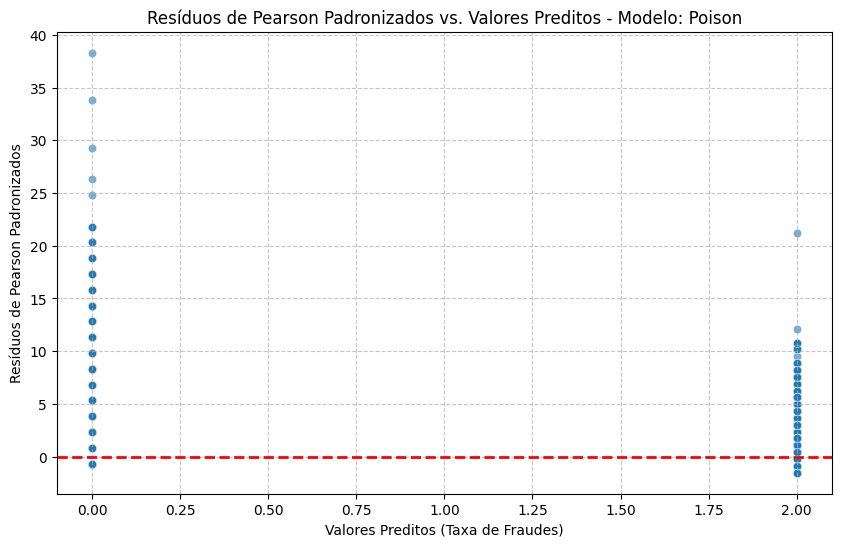

In [295]:
overdisp_plot(modelo_poison_simple, 'Poison')

In [296]:
modelo_poison_complete = smf.glm(formula=features_completa_formula, data=X, family=sm.families.Poisson()).fit()
modelo_poison_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14359
Model:                            GLM   Df Residuals:                    14317
Model Family:                 Poisson   Df Model:                           41
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16958.
Date:                Mon, 02 Jun 2025   Deviance:                       24096.
Time:                        17:37:46   Pearson chi2:                 1.41e+08
No. Iterations:                     7   Pseudo R-squ. (CS):             0.7747
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   4.1855      3.394      1.233      0.218      -2.467      10.838
total_amount                             7.628e-05   1.83e-06     41.738      0.000    7.27e-05    7.99e-05
mean_amount                                -0.0462      0.004    -12.275      0.000      -0.054      -0.039
std_amount                                  0.0031      0.001      2.511      0.012       0.001       0.005
kurtosis_amount                            -0.0004      0.000     -1.867      0.062      -0.001    1.99e-05
mean_current_age                            0.1026      0.019      5.409      0.000       0.065       0.140
std_current_age                            -0.2712      0.028     -9.563      0.000      -0.327      -0.216
kurtosis_current_age                       -0.2070      0.084     -2.459      0.014      -0.372      -0.042
std_per_capita_income                   -1.359e-05   9.35e-06     -1.452      0.146   -3.19e-05    4.75e-06
mean_total_debt                          2.202e-06   7.22e-06      0.305      0.760   -1.19e-05    1.63e-05
std_total_debt                            6.17e-06   4.59e-06      1.343      0.179   -2.83e-06    1.52e-05
mean_credit_score                          -0.0031      0.004     -0.744      0.457      -0.011       0.005
std_credit_score                           -0.0135      0.005     -2.788      0.005      -0.023      -0.004
kurtosis_credit_score                      -0.2202      0.041     -5.362      0.000      -0.301      -0.140
mean_num_credit_cards                       1.6568      0.183      9.068      0.000       1.299       2.015
std_num_credit_cards                        0.2715      0.246      1.102      0.271      -0.212       0.755
kurtosis_num_credit_cards                  -0.1259      0.065     -1.949      0.051      -0.253       0.001
mean_credit_limit                       -8.659e-05   2.52e-05     -3.439      0.001      -0.000   -3.72e-05
kurtosis_credit_limit                       0.0010      0.001      0.748      0.454      -0.002       0.004
use_chip_swipe_transaction                 -0.5465      0.035    -15.466      0.000      -0.616      -0.477
gender_male                                -0.0449      0.503     -0.089      0.929      -1.031       0.941
card_brand_mastercard                       2.8873      0.499      5.791      0.000       1.910       3.865
card_brand_amex                            -1.5376      1.007     -1.527      0.127      -3.512       0.436
card_brand_discover                         4.1048      1.395      2.943      0.003       1.371       6.839
card_type_debit                            -1.7010      0.594     -2.863      0.004      -2.866      -0.536
card_type_debit_prepaid                     2.2324      1.0

In [297]:
overdisp(modelo_poison_complete, df)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.005      
Dependent Variable:     ystar            AIC:                         122969.0408
Date:                   2025-06-02 17:37 BIC:                         122976.6129
No. Observations:       14359            Log-Likelihood:              -61484.    
Df Model:               1                F-statistic:                 76.38      
Df Residuals:           14358            Prob (F-statistic):          2.59e-18   
R-squared (uncentered): 0.005            Scale:                       306.73     
---------------------------------------------------------------------------------------
              Coef.        Std.Err.         t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda         0.7369         0.0843       8.7398       0.0000       0.5716    

O teste de superdispersão indica que existe indicios de superdisperção com 95% de confiança

Aplicando o processo stepwise afim de identificar se a melhor seleção de features ajuda a resolver o problema de superdispersão.

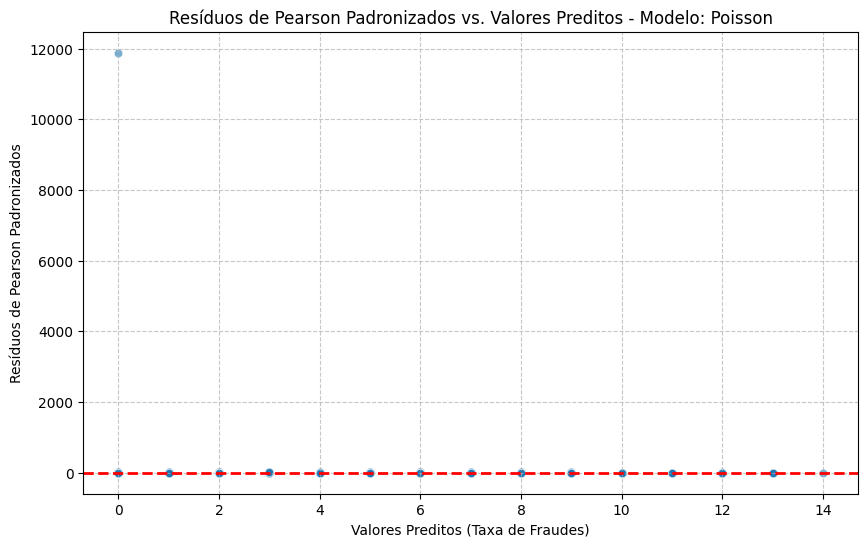

In [298]:
overdisp_plot(modelo_poison_complete, 'Poisson')

In [299]:
modelo_poisson_stepswise = stepwise(modelo_poison_complete, pvalue_limit=0.05)
modelo_poisson_stepswise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('mean_amount') + Q('std_amount') + Q('kurtosis_amount') + Q('mean_current_age') + Q('std_current_age') + Q('kurtosis_current_age') + Q('std_per_capita_income') + Q('mean_total_debt') + Q('std_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('kurtosis_credit_score') + Q('mean_num_credit_cards') + Q('std_num_credit_cards') + Q('kurtosis_num_credit_cards') + Q('mean_credit_limit') + Q('kurtosis_credit_limit') + Q('use_chip_swipe_transaction') + Q('gender_male') + Q('card_brand_mastercard') + Q('card_brand_amex') + Q('card_brand_discover') + Q('card_type_debit') + Q('card_type_debit_prepaid') + Q('has_chip_yes') + Q('online_sales_no') + Q('has_error_yes') + Q('category_arts_entertainment_recreation') + Q('category_sports_recreation') + Q('category_food_beverage') + Q('category_government_utilities') + Q('category_retail_clothing_accessories') + Q('category_financial_insurance') + Q('category_retai

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14359
Model:                            GLM   Df Residuals:                    14329
Model Family:                 Poisson   Df Model:                           29
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16969.
Date:                Mon, 02 Jun 2025   Deviance:                       24118.
Time:                        17:37:57   Pearson chi2:                 3.00e+07
No. Iterations:                     7   Pseudo R-squ. (CS):             0.7743
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        1.8702      1.452      1.288      0.198      -0.976       4.717
Q('total_amount')                             7.799e-05   1.62e-06     48.164      0.000    7.48e-05    8.12e-05
Q('mean_amount')                                -0.0402      0.002    -16.364      0.000      -0.045      -0.035
Q('mean_current_age')                            0.1019      0.018      5.703      0.000       0.067       0.137
Q('std_current_age')                            -0.2719      0.026    -10.407      0.000      -0.323      -0.221
Q('kurtosis_current_age')                       -0.2056      0.082     -2.495      0.013      -0.367      -0.044
Q('std_credit_score')                           -0.0110      0.005     -2.444      0.015      -0.020      -0.002
Q('kurtosis_credit_score')                      -0.2232      0.041     -5.469      0.000      -0.303      -0.143
Q('mean_num_credit_cards')                       1.6603      0.176      9.455      0.000       1.316       2.004
Q('kurtosis_num_credit_cards')                  -0.1522      0.063     -2.406      0.016      -0.276      -0.028
Q('mean_credit_limit')                       -7.914e-05   2.19e-05     -3.610      0.000      -0.000   -3.62e-05
Q('use_chip_swipe_transaction')                 -0.5555      0.035    -15.806      0.000      -0.624      -0.487
Q('card_brand_mastercard')                       3.0599      0.489      6.252      0.000       2.101       4.019
Q('card_brand_discover')                         4.4481      1.379      3.226      0.001       1.746       7.150
Q('card_type_debit')                            -1.4147      0.557     -2.539      0.011      -2.507      -0.322
Q('card_type_debit_prepaid')                     2.9577      0.973      3.041      0.002       1.052       4.864
Q('has_chip_yes')                               -1.6023      0.768     -2.086      0.037      -3.108      -0.097
Q('online_sales_no')                           -12.5165      0.649    -19.294      0.000     -13.788     -11.245
Q('category_arts_entertainment_recreation')     -2.9004      0.865     -3.354      0.001      -4.595      -1.206
Q('category_food_beverage')                      4.2767      0.397     10.781      0.000       3.499       5.054
Q('category_government_utilities')              -6.0406      1.224     -4.935      0.000      -8.439      -3.642
Q('category_retail_clothing_accessories')        4.7384      1.910      2.481      0.013       0.995       8.482
Q('category_financial_insurance')                2.6442      1.086      2.436      0.015       0.517       4.772
Q('category_retail_specialty')                  17.3758      1.103     15.757      0.000      15.214      19.537
Q('category_travel_hospitality')

Aplicando a analise de superdispersão e a "plotagem" do gráfico de valores preditos X os residuos ajustados para comparar como o modelo se comporta em relação a superdispersão.

In [300]:
overdisp(modelo_poisson_stepswise, X)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.005      
Dependent Variable:     ystar            AIC:                         123699.9690
Date:                   2025-06-02 17:37 BIC:                         123707.5412
No. Observations:       14359            Log-Likelihood:              -61849.    
Df Model:               1                F-statistic:                 72.65      
Df Residuals:           14358            Prob (F-statistic):          1.70e-17   
R-squared (uncentered): 0.005            Scale:                       322.74     
---------------------------------------------------------------------------------------
              Coef.        Std.Err.         t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda         0.7382         0.0866       8.5232       0.0000       0.5685    

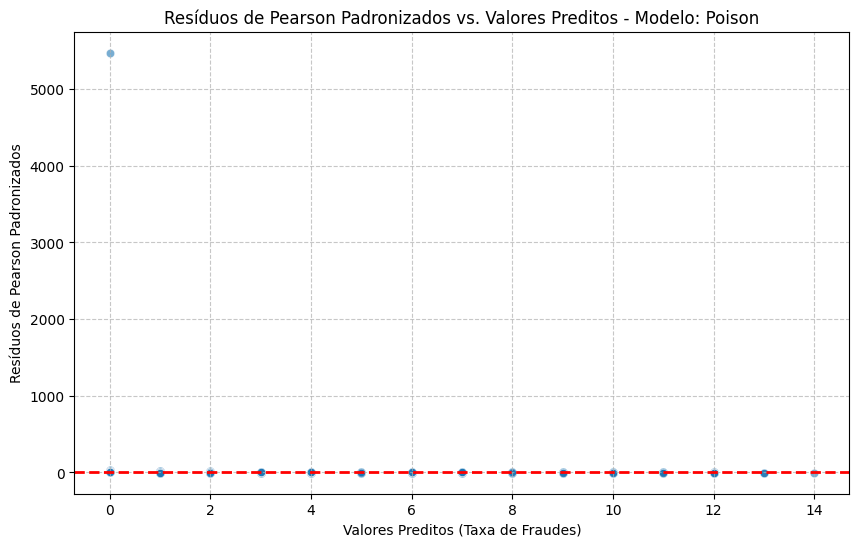

In [301]:
overdisp_plot(modelo_poisson_stepswise, 'Poison')

TODO: Rever

O gráfico evidencia uma caracteristica marcante no problema de superdispersão que é o padrão de "cone" extremamente acentuado, que se abre drasticamente quando os valores preditos se aproximam de zero. Caso o modelo fosse bem ajustado, eperariamos que os resudios estivessem distribuidos em torno de zero, sem padrões visiveis e com uma variancia mais ou menos constante.

In [302]:
summary_col([modelo_poison_simple, modelo_poison_complete, modelo_poisson_stepswise],
            model_names=["Poisson Simples", "Poisson Completo", "Poisson StepWise"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

,Poisson Simples,Poisson Completo,Poisson StepWise
Intercept,-0.8098***,4.1855,1.8702
,(0.0143),(3.3943),(1.4524)
previous_frauds,1.6713***,1.9781***,
,(0.0182),(0.0208),
total_amount,,0.0001***,
,,(0.0000),
mean_amount,,-0.0462***,
,,(0.0038),
std_amount,,0.0031**,
,,(0.0012),


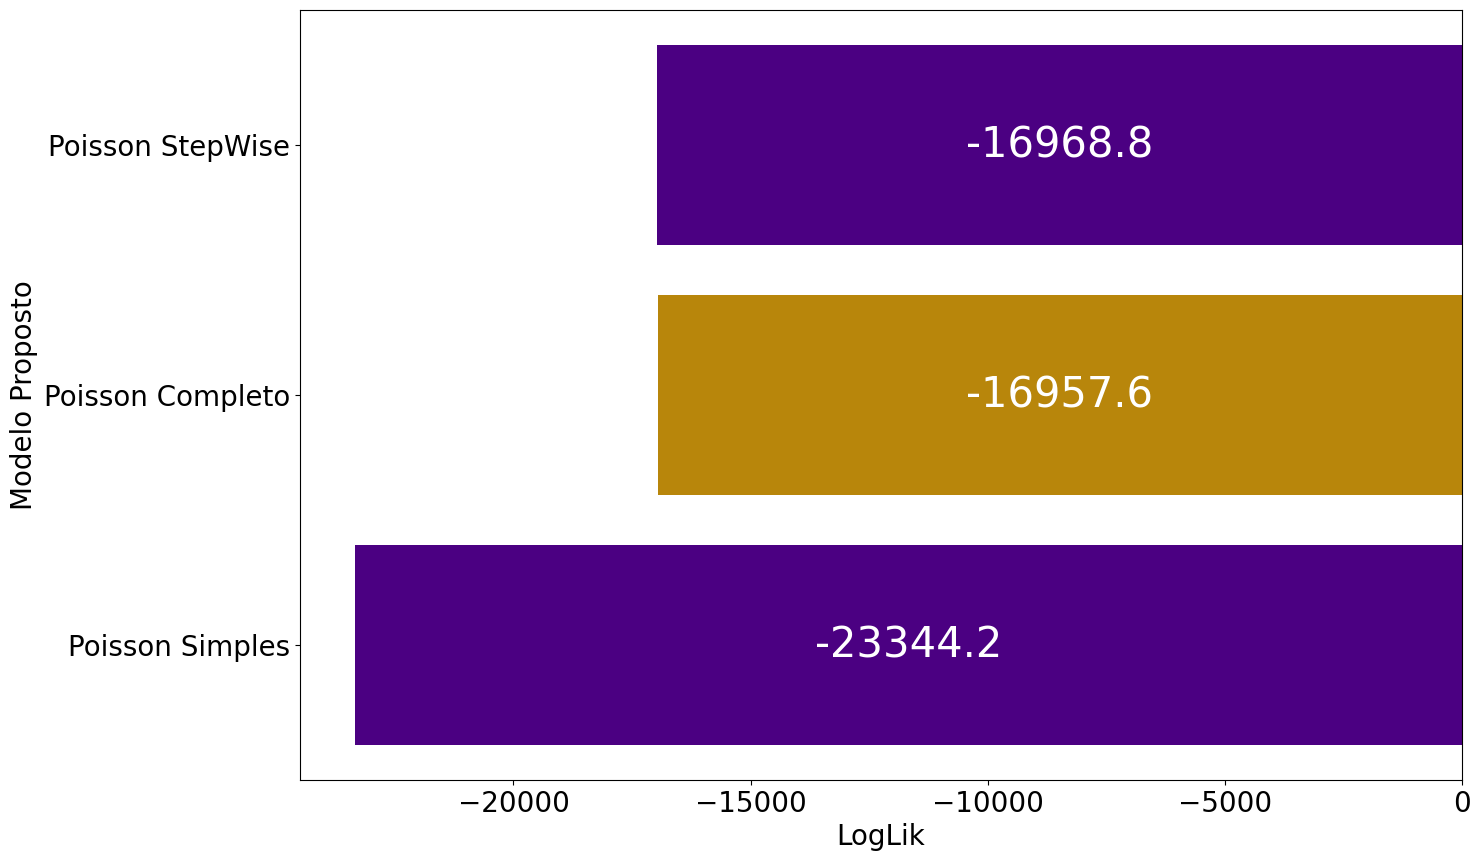

In [303]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf]
})

### Binomial Negative (Poisson-Gama)

In [304]:
result_tests = {}
for column in X.drop(columns=['frauds']).columns[1:]:
  model_test = smf.glm(formula=f'frauds ~ {column}', data=X, family=sm.families.NegativeBinomial()).fit(disp=True)
  result_tests[column] = model_test.pseudo_rsquared()
column_max = list(result_tests.keys())[np.argmax(list(result_tests.values()))]
column_max

'previous_frauds'

In [305]:
modelo_binomialneg_simples = smf.glm(formula=f'frauds ~ {column_max}', data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14361
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16694.
Date:                Mon, 02 Jun 2025   Deviance:                       18553.
Time:                        17:38:00   Pearson chi2:                 4.60e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2556
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.8098      0.017    -47.144      0.000      -0.843      -0.776
previous_frauds     1.6713      0.027     62.337      0.000       1.619       1.724
===================================================================================
"""

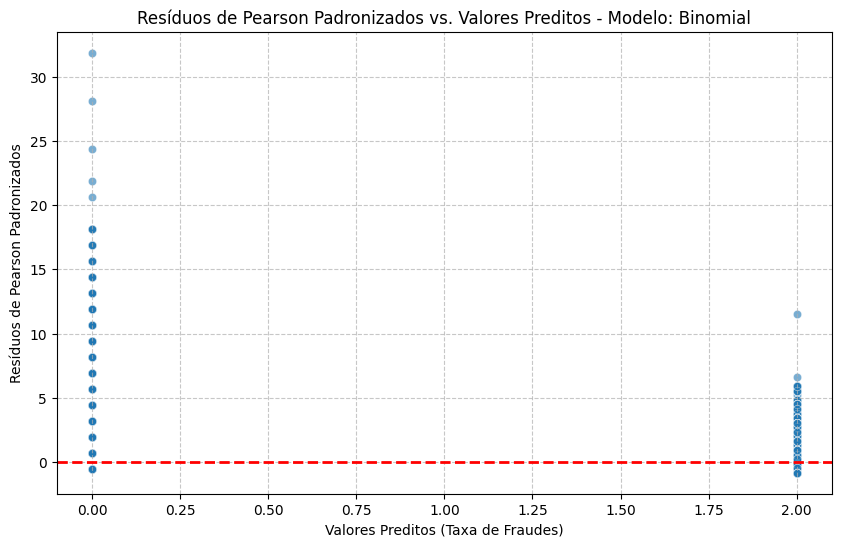

In [306]:
overdisp_plot(modelo_binomialneg_simples, 'Binomial')

In [307]:
modelo_binomialneg_completo = smf.glm(formula=features_completa_formula, data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_completo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14359
Model:                            GLM   Df Residuals:                    14317
Model Family:        NegativeBinomial   Df Model:                           41
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13693.
Date:                Mon, 02 Jun 2025   Deviance:                       12550.
Time:                        17:38:00   Pearson chi2:                 1.88e+07
No. Iterations:                    10   Pseudo R-squ. (CS):             0.5098
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -5.3666      5.034     -1.066      0.286     -15.233       4.499
total_amount                             7.218e-05   2.76e-06     26.171      0.000    6.68e-05    7.76e-05
mean_amount                                -0.0445      0.005     -8.676      0.000      -0.055      -0.034
std_amount                                  0.0044      0.002      2.462      0.014       0.001       0.008
kurtosis_amount                            -0.0006      0.000     -1.575      0.115      -0.001       0.000
mean_current_age                            0.2013      0.028      7.071      0.000       0.146       0.257
std_current_age                            -0.3360      0.042     -7.962      0.000      -0.419      -0.253
kurtosis_current_age                        0.0868      0.119      0.726      0.468      -0.147       0.321
std_per_capita_income                   -1.343e-05   1.46e-05     -0.921      0.357    -4.2e-05    1.52e-05
mean_total_debt                          1.094e-06   1.09e-05      0.100      0.920   -2.03e-05    2.24e-05
std_total_debt                            8.13e-06   7.29e-06      1.116      0.265   -6.15e-06    2.24e-05
mean_credit_score                           0.0010      0.006      0.159      0.873      -0.011       0.013
std_credit_score                           -0.0127      0.007     -1.763      0.078      -0.027       0.001
kurtosis_credit_score                      -0.3084      0.057     -5.369      0.000      -0.421      -0.196
mean_num_credit_cards                       1.9021      0.274      6.932      0.000       1.364       2.440
std_num_credit_cards                        0.3315      0.369      0.900      0.368      -0.391       1.054
kurtosis_num_credit_cards                  -0.0535      0.100     -0.538      0.591      -0.249       0.142
mean_credit_limit                       -4.593e-05   3.83e-05     -1.200      0.230      -0.000    2.91e-05
kurtosis_credit_limit                      -0.0029      0.002     -1.239      0.215      -0.007       0.002
use_chip_swipe_transaction                 -0.6526      0.056    -11.708      0.000      -0.762      -0.543
gender_male                                -0.6111      0.745     -0.820      0.412      -2.072       0.850
card_brand_mastercard                       3.7702      0.753      5.008      0.000       2.295       5.246
card_brand_amex                            -1.7847      1.530     -1.167      0.243      -4.783       1.213
card_brand_discover                         1.3063      2.126      0.615      0.539      -2.860       5.472
card_type_debit                            -3.3971      0.903     -3.762      0.000      -5.167      -1.627
card_type_debit_prepaid                     3.6586      1.5

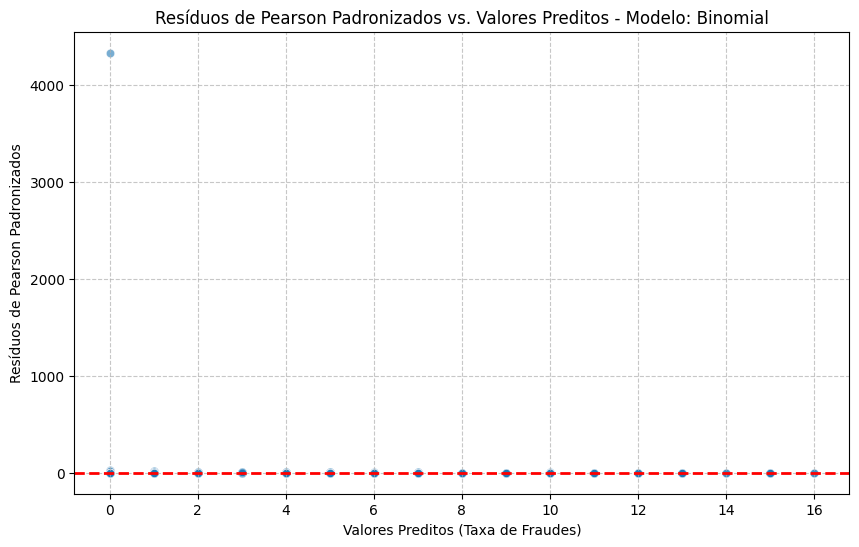

In [308]:
overdisp_plot(modelo_binomialneg_completo, 'Binomial')

In [309]:
modelo_binomialneg_stepwise = stepwise(modelo_binomialneg_completo, pvalue_limit=0.05)
modelo_binomialneg_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('mean_amount') + Q('std_amount') + Q('kurtosis_amount') + Q('mean_current_age') + Q('std_current_age') + Q('kurtosis_current_age') + Q('std_per_capita_income') + Q('mean_total_debt') + Q('std_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('kurtosis_credit_score') + Q('mean_num_credit_cards') + Q('std_num_credit_cards') + Q('kurtosis_num_credit_cards') + Q('mean_credit_limit') + Q('kurtosis_credit_limit') + Q('use_chip_swipe_transaction') + Q('gender_male') + Q('card_brand_mastercard') + Q('card_brand_amex') + Q('card_brand_discover') + Q('card_type_debit') + Q('card_type_debit_prepaid') + Q('has_chip_yes') + Q('online_sales_no') + Q('has_error_yes') + Q('category_arts_entertainment_recreation') + Q('category_sports_recreation') + Q('category_food_beverage') + Q('category_government_utilities') + Q('category_retail_clothing_accessories') + Q('category_financial_insurance') + Q('category_retai

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14359
Model:                            GLM   Df Residuals:                    14337
Model Family:        NegativeBinomial   Df Model:                           21
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13708.
Date:                Mon, 02 Jun 2025   Deviance:                       12580.
Time:                        17:38:06   Pearson chi2:                 1.93e+07
No. Iterations:                    10   Pseudo R-squ. (CS):             0.5088
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -7.4603      1.619     -4.608      0.000     -10.633      -4.287
Q('total_amount')                             7.152e-05   2.36e-06     30.353      0.000    6.69e-05    7.61e-05
Q('mean_amount')                                -0.0435      0.004    -10.204      0.000      -0.052      -0.035
Q('std_amount')                                  0.0028      0.001      2.227      0.026       0.000       0.005
Q('mean_current_age')                            0.1930      0.025      7.596      0.000       0.143       0.243
Q('std_current_age')                            -0.3288      0.037     -8.971      0.000      -0.401      -0.257
Q('kurtosis_credit_score')                      -0.3046      0.056     -5.427      0.000      -0.415      -0.195
Q('mean_num_credit_cards')                       1.9729      0.257      7.683      0.000       1.470       2.476
Q('use_chip_swipe_transaction')                 -0.6496      0.055    -11.883      0.000      -0.757      -0.542
Q('card_brand_mastercard')                       4.0051      0.733      5.467      0.000       2.569       5.441
Q('card_type_debit')                            -3.6033      0.789     -4.564      0.000      -5.151      -2.056
Q('card_type_debit_prepaid')                     4.4936      1.435      3.131      0.002       1.680       7.307
Q('online_sales_no')                           -10.7806      0.988    -10.916      0.000     -12.716      -8.845
Q('category_arts_entertainment_recreation')     -3.8540      1.172     -3.287      0.001      -6.152      -1.556
Q('category_food_beverage')                      4.7210      0.571      8.273      0.000       3.603       5.839
Q('category_financial_insurance')                4.1665      1.625      2.564      0.010       0.981       7.352
Q('category_retail_specialty')                  17.7300      1.677     10.571      0.000      14.443      21.017
Q('category_health_medical')                     2.9286      1.345      2.177      0.030       0.292       5.566
Q('category_professional_business_services')    -6.2699      2.628     -2.386      0.017     -11.421      -1.119
Q('category_construction_contractors')          73.2834     13.803      5.309      0.000      46.229     100.337
Q('category_retail_home_garden')                 8.3953      1.934      4.342      0.000       4.606      12.185
Q('previous_frauds')                             2.0606      0.034     60.579      0.000       1.994       2.127
================================================================================================================
"""

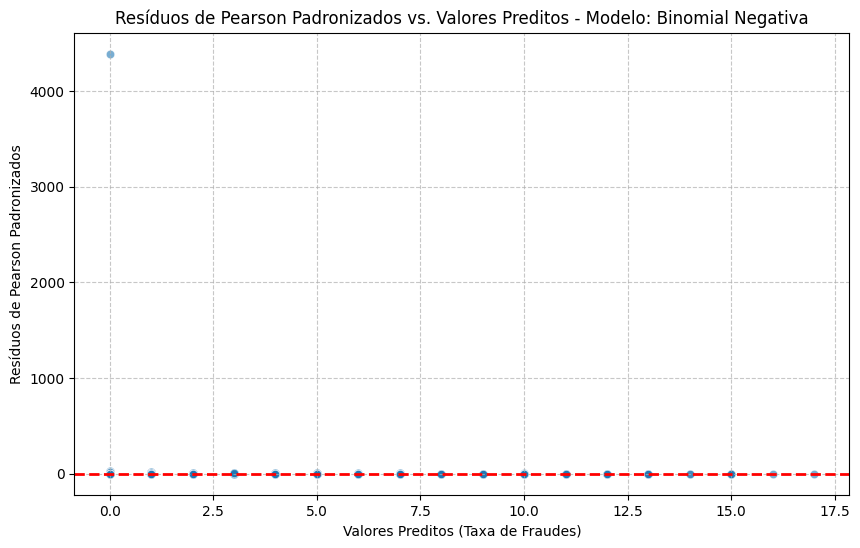

In [310]:
overdisp_plot(modelo_binomialneg_stepwise, 'Binomial Negativa')

In [311]:
lrtest([modelo_binomialneg_completo, modelo_binomialneg_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): -29.36
p-value: 1.000

==================Result======================== 

H0: Models with log-likelihoods that are not statistically different at 95% confidence level


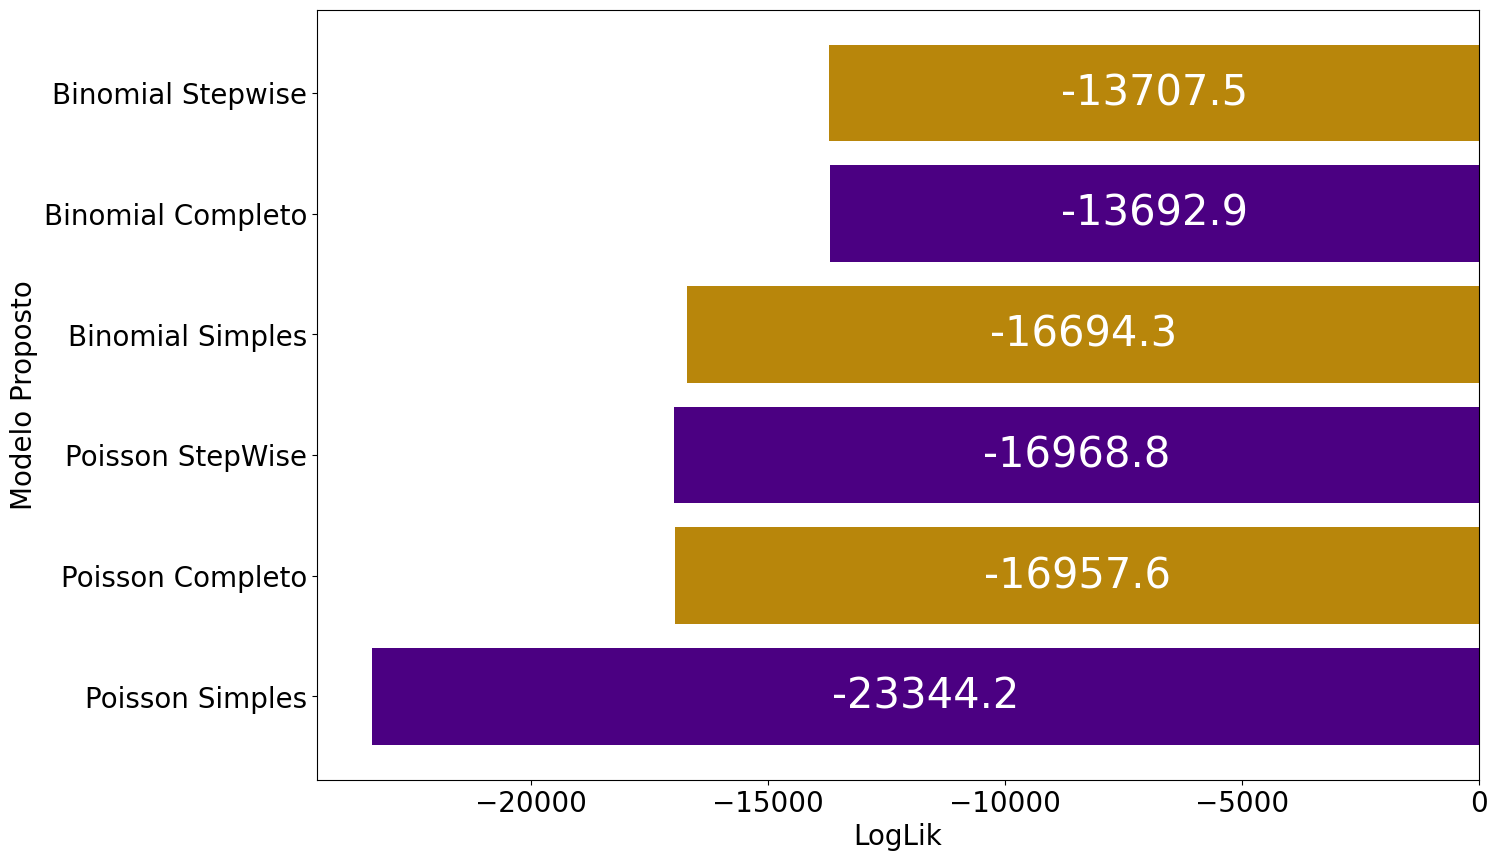

In [312]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise', 'Binomial Simples', 'Binomial Completo', 'Binomial Stepwise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf, modelo_binomialneg_simples.llf, modelo_binomialneg_completo.llf, modelo_binomialneg_stepwise.llf]
})

### Zero Inflated Poison

In [315]:
# categories_columns = [column for column in  X.columns if 'category_' in column]
# categories_columns.append('previous_frauds')

In [366]:
X_log = X.drop(columns=['frauds', 'previous_frauds']).copy()
for column in X_log.columns:
  X_log[column] = np.log(X_log[column] + 1)
X_log = pd.concat([X_log, X['previous_frauds']], axis=1)
X_log.head()

,total_amount,mean_amount,std_amount,kurtosis_amount,mean_current_age,std_current_age,kurtosis_current_age,std_per_capita_income,mean_total_debt,std_total_debt,...,category_government_utilities,category_retail_clothing_accessories,category_financial_insurance,category_retail_specialty,category_travel_hospitality,category_health_medical,category_professional_business_services,category_construction_contractors,category_retail_home_garden,previous_frauds
0,8.562406,3.704337,3.864859,1.773835,4.018701,2.781098,0.209581,9.004920,10.972032,10.741986,...,0.039221,0.019803,0.067659,0.039221,0.00995,0.029559,0.009950,0.0,0.00000,0
1,10.266051,3.593181,4.104008,5.037560,4.035644,2.774908,-0.244346,9.319943,10.945473,10.853737,...,0.009950,0.000000,0.048790,0.019803,0.00000,0.039221,0.000000,0.0,0.00995,0
2,10.616124,3.993524,4.421440,4.480294,4.049284,2.849613,-0.680010,9.522648,10.902716,10.870129,...,0.009950,0.009950,0.048790,0.009950,0.00995,0.029559,0.000000,0.0,0.00995,0
3,10.126334,3.971532,4.139706,3.795966,4.032765,2.757838,-0.461100,9.489291,10.896100,10.791436,...,0.019803,0.009950,0.048790,0.000000,0.00000,0.019803,0.000000,0.0,0.00995,0
4,9.056481,4.359699,4.813856,3.190677,4.031286,2.684104,-0.269403,9.015432,10.957843,10.611173,...,0.048790,0.000000,0.048790,0.039221,0.00000,0.076961,0.029559,0.0,0.04879,1


In [367]:
exclude_columns = X_log.isna().sum().reset_index().rename(columns={0:'missing'}).query('missing > 0')['index'].to_list()
X_droped = X.drop(columns=exclude_columns)

In [368]:
exclude_columns

['std_amount',
 'kurtosis_amount',
 'std_current_age',
 'kurtosis_current_age',
 'std_per_capita_income',
 'std_total_debt',
 'std_credit_score',
 'kurtosis_credit_score',
 'std_num_credit_cards',
 'kurtosis_num_credit_cards',
 'kurtosis_credit_limit']

In [369]:
X_droped.columns.to_list()

['frauds',
 'total_amount',
 'mean_amount',
 'mean_current_age',
 'mean_total_debt',
 'mean_credit_score',
 'mean_num_credit_cards',
 'mean_credit_limit',
 'use_chip_swipe_transaction',
 'gender_male',
 'card_brand_mastercard',
 'card_brand_amex',
 'card_brand_discover',
 'card_type_debit',
 'card_type_debit_prepaid',
 'has_chip_yes',
 'online_sales_no',
 'has_error_yes',
 'category_arts_entertainment_recreation',
 'category_sports_recreation',
 'category_food_beverage',
 'category_government_utilities',
 'category_retail_clothing_accessories',
 'category_financial_insurance',
 'category_retail_specialty',
 'category_travel_hospitality',
 'category_health_medical',
 'category_professional_business_services',
 'category_construction_contractors',
 'category_retail_home_garden',
 'previous_frauds']

In [372]:
standard_scaler = StandardScaler()
X_scaler = standard_scaler.fit_transform(X_droped.drop(columns=['frauds']))

X_scaler = pd.DataFrame(X_scaler, columns=X_droped.drop(columns=['frauds']).columns)
X_scaler.head()

,total_amount,mean_amount,mean_current_age,mean_total_debt,mean_credit_score,mean_num_credit_cards,mean_credit_limit,use_chip_swipe_transaction,gender_male,card_brand_mastercard,...,category_government_utilities,category_retail_clothing_accessories,category_financial_insurance,category_retail_specialty,category_travel_hospitality,category_health_medical,category_professional_business_services,category_construction_contractors,category_retail_home_garden,previous_frauds
0,-1.642199,-0.899793,0.631691,0.139048,0.433784,0.977937,0.886454,0.859952,-0.202483,1.546719,...,0.396781,1.914060,1.637772,0.886234,0.653641,-2.247263,0.236237,-0.066378,-2.373425,-0.552282
1,-0.071814,-1.165274,1.495333,-0.396071,0.396358,1.323309,-0.615740,0.972364,-0.202483,1.203638,...,-1.243210,-1.435924,0.048251,-0.454435,-0.315518,-1.652353,-0.914345,-0.066378,-1.529918,-0.552282
2,0.732925,-0.053538,2.201350,-1.228235,0.415782,0.270757,0.402064,0.888055,0.498979,0.517476,...,-1.243210,0.239068,0.048251,-1.124769,0.653641,-2.247263,-0.914345,-0.066378,-1.529918,-0.552282
3,-0.322151,-0.126839,1.347536,-1.353866,-1.526773,-0.266343,-0.795174,0.972364,-0.553214,0.860557,...,-0.696546,0.239068,0.048251,-1.795104,-0.315518,-2.842174,-0.914345,-0.066378,-1.529918,-0.552282
4,-1.418909,1.436620,1.271822,-0.148610,0.262748,0.482580,-1.495999,0.859952,2.252633,-1.884092,...,0.943445,-1.435924,0.048251,0.886234,-0.315518,0.727287,2.537400,-0.066378,1.844111,1.810669


In [373]:
result_tests = {}
for column in X_scaler.columns:
  X1 = X_scaler[column]
  X1 = sm.add_constant(X1)

  modelo_zip_test = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='probit').fit(disp=False, cov_type='HC0')# sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='probit').fit(cov_type='HC0', disp=False)
  result_tests[column] = modelo_zip_test.prsquared

column_max = list(result_tests.keys())[np.argmax(list(result_tests.values()))]
column_max

'total_amount'

In [390]:
X1 = X_scaler[column_max].copy()
X1 = sm.add_constant(X1)

In [391]:
modelo_zip_simples = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='probit').fit(disp=False, cov_type='HC0')
modelo_zip_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14361
Method:                            MLE   Df Model:                            1
Date:                 Mon, 02 Jun 2025   Pseudo R-squ.:                 0.07254
Time:                         18:19:47   Log-Likelihood:                -15512.
converged:                        True   LL-Null:                       -16726.
Covariance Type:                   HC0   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
inflate_const               0.7756      0.013     60.391      0.000       0.750       0.801
inflate_previous_frauds    -0.4962      0.011    -43.609      0.000      -0.519      -0.474
const                       1.1905      0.022     55.064      0.000       1.148       1.233
previous_frauds             0.1496      0.014     10.322      0.000       0.121       0.178
===========================================================================================
"""

In [392]:
vuong_test(modelo_poison_simple, modelo_zip_simples)

Optimization terminated successfully.
         Current function value: 1.625302
         Iterations 6
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -31.833
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [393]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [394]:
modelo_zip_complete = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='probit').fit(disp=False, cov_type='HC0')
modelo_zip_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14332
Method:                            MLE   Df Model:                           30
Date:                 Mon, 02 Jun 2025   Pseudo R-squ.:                  0.2169
Time:                         18:20:23   Log-Likelihood:                -13097.
converged:                       False   LL-Null:                       -16726.
Covariance Type:                   HC0   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       0.5105      0.048     10.663      0.000       0.417       0.604
inflate_total_amount                               -0.0669      0.058     -1.155      0.248      -0.180       0.047
inflate_mean_amount                                 0.1526      0.066      2.326      0.020       0.024       0.281
inflate_mean_current_age                           -0.1877      0.036     -5.227      0.000      -0.258      -0.117
inflate_mean_total_debt                            -0.0974      0.029     -3.351      0.001      -0.154      -0.040
inflate_mean_credit_score                          -0.0397      0.030     -1.324      0.186      -0.099       0.019
inflate_mean_num_credit_cards                      -0.0761      0.031     -2.449      0.014      -0.137      -0.015
inflate_mean_credit_limit                           0.0688      0.030      2.283      0.022       0.010       0.128
inflate_use_chip_swipe_transaction                  0.2385      0.023     10.243      0.000       0.193       0.284
inflate_gender_male                                 0.0376      0.027      1.377      0.168      -0.016       0.091
inflate_card_brand_mastercard                       0.0043      0.029      0.148      0.882      -0.052       0.061
inflate_card_brand_amex                             0.0088      0.028      0.313      0.754      -0.047       0.064
inflate_card_brand_discover                         0.0497      0.025      1.996      0.046       0.001       0.098
inflate_card_type_debit                             0.0550      0.033      1.692      0.091      -0.009       0.119
inflate_card_type_debit_prepaid                    -0.0708      0.030     -2.347      0.019      -0.130      -0.012
inflate_has_chip_yes                               -0.0462      0.024     -1.937      0.053      -0.093       0.001
inflate_online_sales_no                             0.1211      0.052      2.347      0.019       0.020       0.222
inflate_has_error_yes                               0.0283      0.022      1.291      0.197      -0.015       0.071
inflate_category_arts_entertainment_recreation      0.2078      0.034      6.092      0.000       0.141       0.275
inflate_category_sports_recreation                 -0.0070      0.025     -0.285      0.776      -0.055       0.041
inflate_category_food_beverage                     -0.1643      0.043     -3.793      0.000      -0.249      -0.079
inflate_category_government_utilities              -0.1708      0.042     -4.036      0.000      -0.254      -0.088
inflate_category_retail_clothing_accessories       -0.0326      0.021     -1.564      0.118      -0.073       0.008
inflate_category_financial_insurance               -0.0054      0.026     -0.205      0.838      -0.057       0.046
inflate_category_retail_specialty                  -0.2078      0.033     -6.223      0.000      -0.

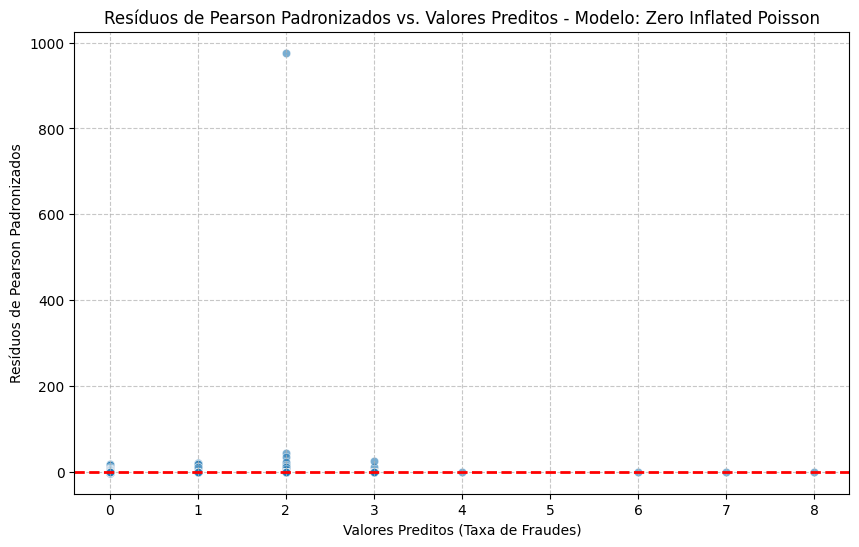

In [395]:
overdisp_plot(modelo_zip_complete, 'Zero Inflated Poisson')

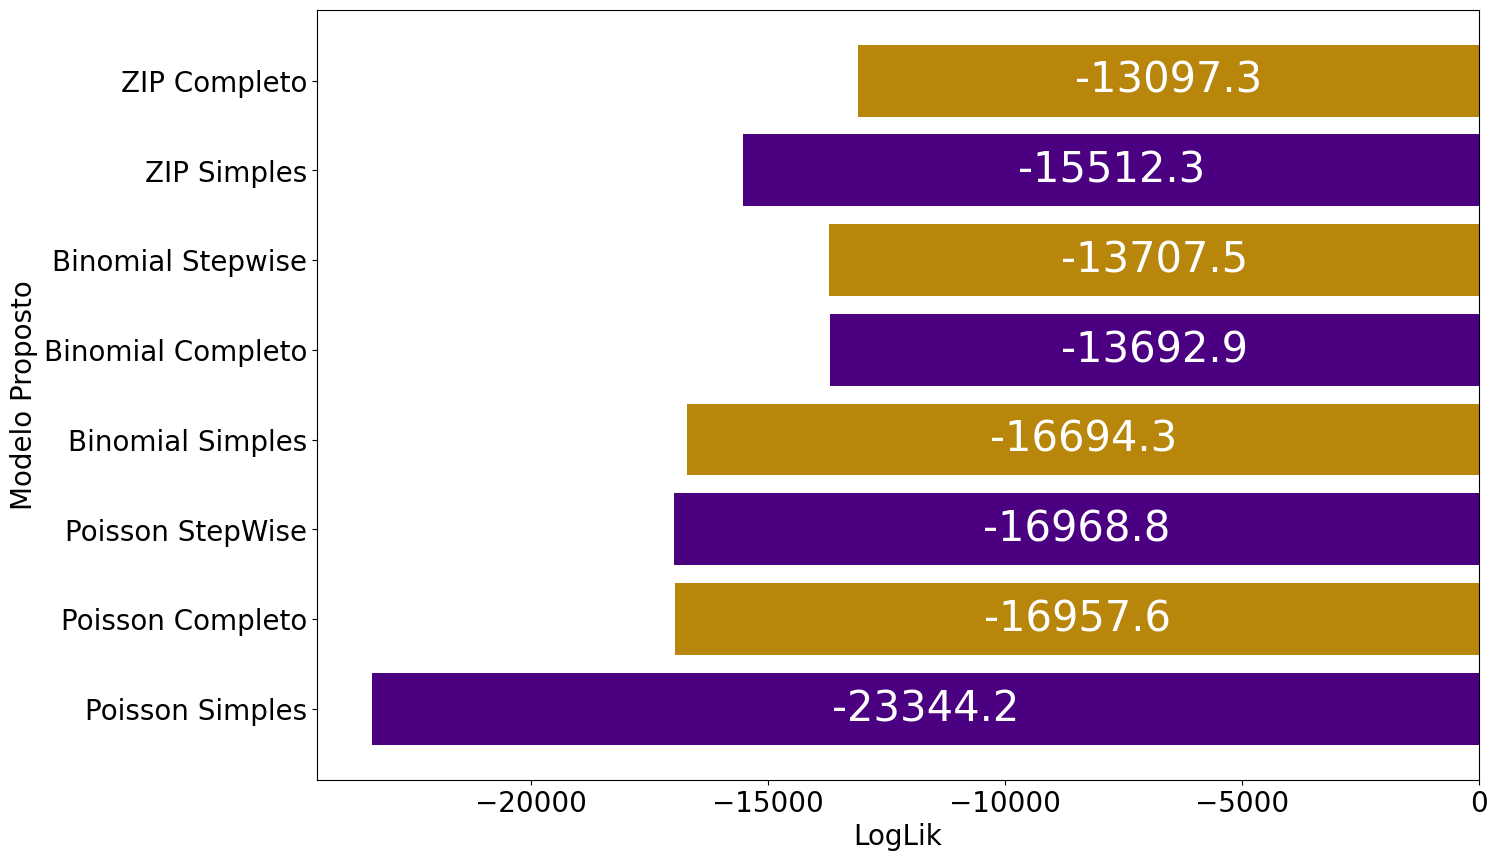

In [396]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf
      ]
})

In [397]:
df_features_zip_complete = modelo_zip_complete.pvalues.where(lambda x: x < 0.05).dropna().reset_index().rename(columns={'index':'Features', 0:'P-Value'})
feature_exog = list(filter(lambda x: x!='const', df_features_zip_complete.query('~Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas')
print(feature_exog)
feature_exog_inflate = list(filter(lambda x: x!='const', df_features_zip_complete.query('Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas Inflado')
print(feature_exog_inflate)

Exogenas
['total_amount', 'mean_amount', 'mean_num_credit_cards', 'use_chip_swipe_transaction', 'card_brand_mastercard', 'card_brand_discover', 'has_chip_yes', 'online_sales_no', 'category_arts_entertainment_recreation', 'category_food_beverage', 'category_government_utilities', 'category_retail_specialty', 'category_retail_home_garden', 'previous_frauds']
Exogenas Inflado
['mean_amount', 'mean_current_age', 'mean_total_debt', 'mean_num_credit_cards', 'mean_credit_limit', 'use_chip_swipe_transaction', 'card_brand_discover', 'card_type_debit_prepaid', 'online_sales_no', 'category_arts_entertainment_recreation', 'category_food_beverage', 'category_government_utilities', 'category_retail_specialty', 'previous_frauds']


In [398]:
X1 = X_scaler[feature_exog].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[feature_exog_inflate].copy()
X2 = sm.add_constant(X2)

modelo_zip_complete_filter = sm.ZeroInflatedPoisson(y, X1, exog_infl=X2, inflation='probit').fit(disp=False, cov_type='HC0')
modelo_zip_complete_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14348
Method:                            MLE   Df Model:                           14
Date:                 Mon, 02 Jun 2025   Pseudo R-squ.:                  0.2146
Time:                         18:20:42   Log-Likelihood:                -13136.
converged:                       False   LL-Null:                       -16726.
Covariance Type:                   HC0   LLR p-value:                     0.000
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
inflate_const                                      0.4973      0.034     14.745      0.000       0.431       0.563
inflate_mean_amount                                0.0797      0.064      1.239      0.215      -0.046       0.206
inflate_mean_current_age                          -0.2015      0.033     -6.068      0.000      -0.267      -0.136
inflate_mean_total_debt                           -0.1075      0.027     -3.945      0.000      -0.161      -0.054
inflate_mean_num_credit_cards                     -0.0798      0.029     -2.736      0.006      -0.137      -0.023
inflate_mean_credit_limit                          0.0870      0.027      3.230      0.001       0.034       0.140
inflate_use_chip_swipe_transaction                 0.2526      0.020     12.358      0.000       0.213       0.293
inflate_card_brand_discover                        0.0436      0.024      1.792      0.073      -0.004       0.091
inflate_card_type_debit_prepaid                   -0.0974      0.027     -3.597      0.000      -0.150      -0.044
inflate_online_sales_no                            0.0686      0.050      1.372      0.170      -0.029       0.167
inflate_category_arts_entertainment_recreation     0.2454      0.029      8.332      0.000       0.188       0.303
inflate_category_food_beverage                    -0.1110      0.030     -3.640      0.000      -0.171      -0.051
inflate_category_government_utilities             -0.1412      0.044     -3.225      0.001      -0.227      -0.055
inflate_category_retail_specialty                 -0.1937      0.033     -5.907      0.000      -0.258      -0.129
inflate_previous_frauds                           -0.8361      0.022    -37.228      0.000      -0.880      -0.792
const                                              0.2403      0.044      5.438      0.000       0.154       0.327
total_amount                                       1.0323      0.037     27.726      0.000       0.959       1.105
mean_amount                                       -0.4612      0.067     -6.872      0.000      -0.593      -0.330
mean_num_credit_cards                              0.0804      0.024      3.337      0.001       0.033       0.128
use_chip_swipe_transaction                         0.0790      0.018      4.429      0.000       0.044       0.114
card_brand_mastercard                              0.1033      0.021      4.938      0.000       0.062       0.144
card_brand_discover                                0.0601      0.022      2.782      0.005       0.018       0.102
has_chip_yes                                      -0.0440      0.021     -2.140      0.032      -0.084      -0.004
online_sales_no                                   -0.2760      0.037     -7.510      0.000      -0.348      -0.204
category_arts_entertainment_recreation             0.1145      0.030      3.761      0.000       0.055       0.174
category_foo

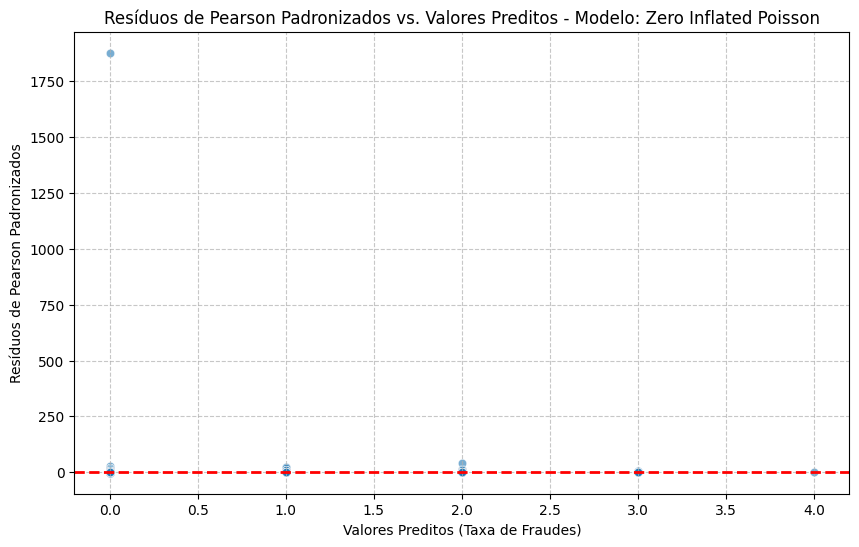

In [399]:
overdisp_plot(modelo_zip_complete_filter, 'Zero Inflated Poisson')

In [400]:
step_wise = StepwiseZeroInflated(alpha=0.05, model_type='ZIP', verbose=True, model_params=dict(inflation='probit'), fit_params=dict(cov_type='HC0', disp=False), batch_size=3, parallel_features=True)
step_wise.fit_transform(X_scaler, y)

STEPWISE OTIMIZADO INICIADO
Cache habilitado: True
Processamento paralelo: True
Critério inicial: 33455.20
------------------------------------------------------------
Iteração 1: testando batch de 3 features
Iteração 1: testando batch de 3 features
Iteração 1: testando batch de 3 features
Iteração 1: testando batch de 3 features
Iteração 1: testando batch de 3 features
Iteração 1: testando batch de 3 features
Iteração 1: testando batch de 3 features
Iteração 1: testando batch de 3 features
Iteração 1: testando batch de 3 features
Iteração 1: testando batch de 3 features
Adicionada 'total_amount' como exog (melhoria: 2537.81)
Iteração 2: testando batch de 3 features
Iteração 2: testando batch de 3 features
Iteração 2: testando batch de 3 features
Iteração 2: testando batch de 3 features
Iteração 2: testando batch de 3 features
Iteração 2: testando batch de 3 features
Iteração 2: testando batch de 3 features
Iteração 2: testando batch de 3 features
Iteração 2: testando batch de 3 featur

{'exog': array([[-1.64219898, -0.55228203, -0.89979339, ...,  2.58309366,
          0.43378354, -2.24726343],
        [-0.07181383, -0.55228203, -1.16527416, ...,  1.9514587 ,
          0.3963576 , -1.65235328],
        [ 0.7329253 , -0.55228203, -0.05353803, ...,  0.05655382,
          0.41578232, -2.24726343],
        ...,
        [ 0.81997249, -0.55228203, -0.83500565, ...,  0.68818878,
         -1.02653603, -0.462533  ],
        [ 1.08014213, -0.55228203, -0.30278104, ...,  0.05655382,
          0.19445989,  0.72728728],
        [-0.42588764, -0.55228203,  0.4704458 , ..., -0.57508114,
         -0.35311397, -0.462533  ]]),
 'inf': array([[-0.55228203, -0.89979339,  0.88623415, -0.02218287,  0.97793655,
          0.43378354],
        [-0.55228203, -1.16527416, -0.45443478, -0.02218287,  1.32330887,
          0.3963576 ],
        [-0.55228203, -0.05353803, -1.12476924,  0.39052778,  0.27075703,
          0.41578232],
        ...,
        [-0.55228203, -0.83500565,  0.88623415, -0.847

In [401]:
modelo_zip_stepwise = step_wise.final_model_
modelo_zip_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14352
Method:                            MLE   Df Model:                           10
Date:                 Mon, 02 Jun 2025   Pseudo R-squ.:                  0.1992
Time:                         18:26:16   Log-Likelihood:                -13393.
converged:                        True   LL-Null:                       -16726.
Covariance Type:                   HC0   LLR p-value:                     0.000
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
inflate_const                                      0.5925      0.025     23.612      0.000       0.543       0.642
inflate_previous_frauds                           -0.7884      0.022    -35.168      0.000      -0.832      -0.744
inflate_mean_amount                                0.3528      0.055      6.387      0.000       0.245       0.461
inflate_category_retail_specialty                 -0.1452      0.032     -4.467      0.000      -0.209      -0.081
inflate_category_arts_entertainment_recreation     0.2438      0.025      9.757      0.000       0.195       0.293
inflate_mean_num_credit_cards                     -0.0695      0.025     -2.771      0.006      -0.119      -0.020
inflate_mean_credit_score                         -0.0538      0.026     -2.050      0.040      -0.105      -0.002
const                                              0.3270      0.042      7.725      0.000       0.244       0.410
total_amount                                       0.9166      0.030     30.321      0.000       0.857       0.976
previous_frauds                                    0.2116      0.019     11.332      0.000       0.175       0.248
mean_amount                                       -0.3859      0.071     -5.426      0.000      -0.525      -0.246
category_retail_specialty                          0.1452      0.029      5.077      0.000       0.089       0.201
category_arts_entertainment_recreation             0.0679      0.030      2.228      0.026       0.008       0.128
mean_num_credit_cards                              0.0999      0.024      4.122      0.000       0.052       0.147
card_brand_mastercard                              0.0905      0.021      4.252      0.000       0.049       0.132
card_type_debit_prepaid                            0.0652      0.023      2.888      0.004       0.021       0.109
mean_credit_score                                 -0.0647      0.026     -2.489      0.013      -0.116      -0.014
category_health_medical                           -0.0465      0.022     -2.124      0.034      -0.089      -0.004
==================================================================================================================
"""

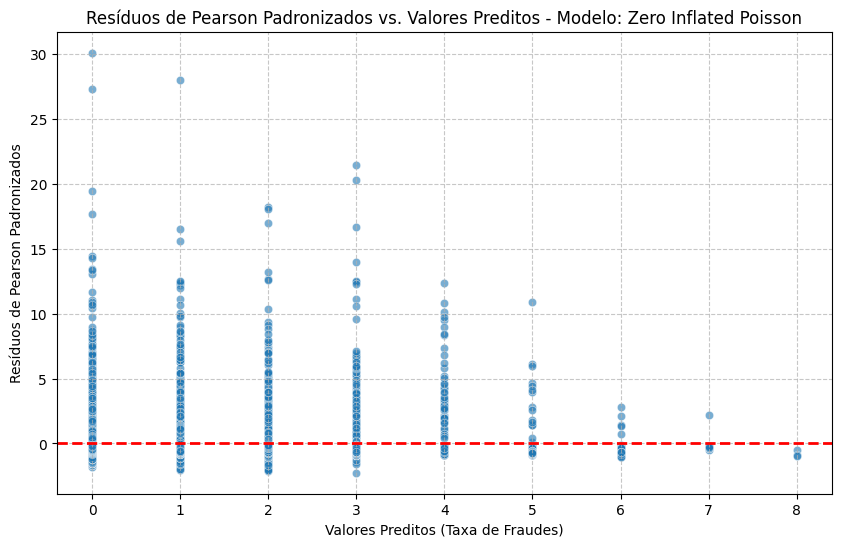

In [403]:
overdisp_plot(modelo_zip_stepwise, 'Zero Inflated Poisson')

In [404]:
lrtest([modelo_zip_stepwise, modelo_zip_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): -0.0
p-value: 1.000

==================Result======================== 

H0: Models with log-likelihoods that are not statistically different at 95% confidence level


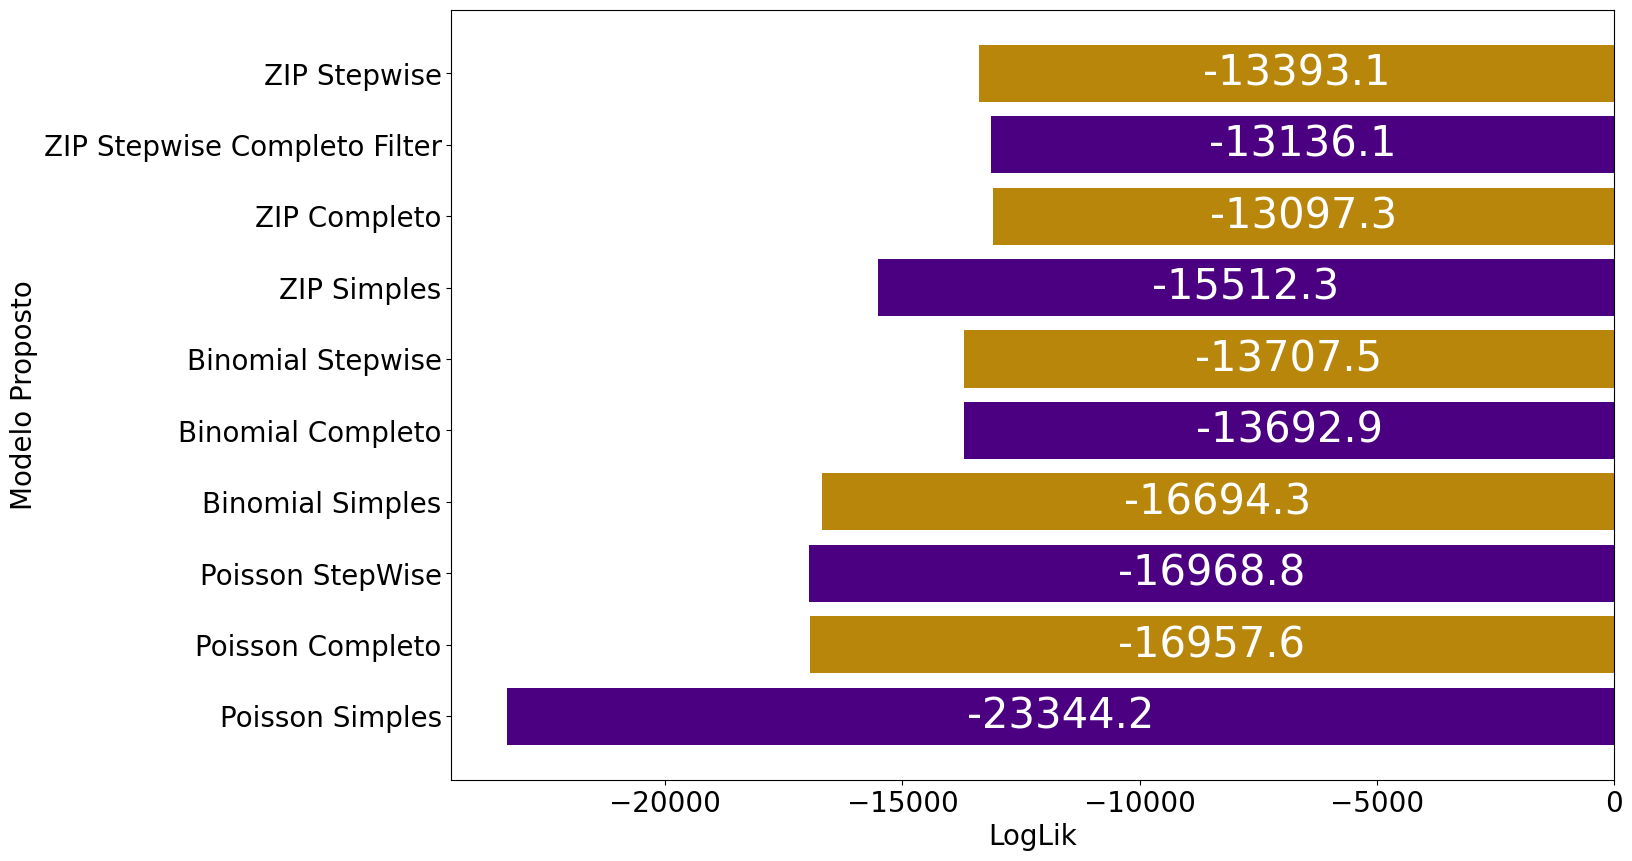

In [405]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise Completo Filter',
        'ZIP Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_complete_filter.llf,
        modelo_zip_stepwise.llf
      ]
})

### ZINB - Zero Inflated Negative Benomial

In [406]:
result_tests = {}
for column in X_scaler.columns:
  X1 = X_scaler[column]
  X1 = sm.add_constant(X1)

  modelo_zbneg_test = sm.ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='probit').fit(disp=False, cov_type='HC0')
  result_tests[column] = modelo_zbneg_test.prsquared

column_max = list(result_tests.keys())[np.argmax(list(result_tests.values()))]
column_max

'previous_frauds'

In [407]:
X1 = X_scaler[column_max].copy()
X1 = sm.add_constant(X1)

In [408]:
modelo_zinb_simples = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='probit').fit(disp=False, cov_type='HC0')
modelo_zinb_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                14363
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    14361
Method:                                      MLE   Df Model:                            1
Date:                           Mon, 02 Jun 2025   Pseudo R-squ.:                 0.06985
Time:                                   18:28:37   Log-Likelihood:                -14121.
converged:                                  True   LL-Null:                       -15182.
Covariance Type:                             HC0   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
inflate_const              -2.0175      0.822     -2.454      0.014      -3.629      -0.406
inflate_previous_frauds    -4.6730      1.472     -3.174      0.002      -7.558      -1.787
const                       0.5384      0.033     16.341      0.000       0.474       0.603
previous_frauds             0.1784      0.019      9.238      0.000       0.141       0.216
alpha                       2.2401      0.077     29.124      0.000       2.089       2.391
===========================================================================================
"""

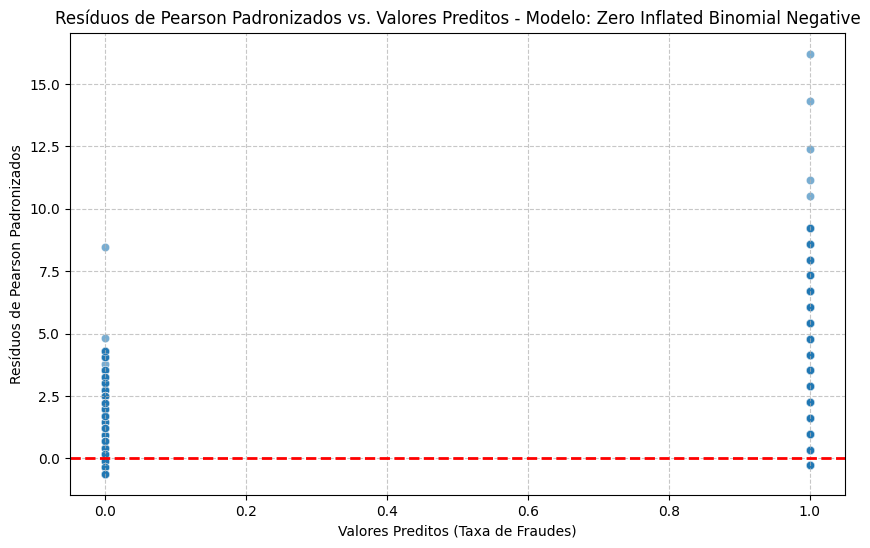

In [409]:
overdisp_plot(modelo_zinb_simples, 'Zero Inflated Binomial Negative')

In [410]:
vuong_test(modelo_binomialneg_simples, modelo_zinb_simples)

Optimization terminated successfully.
         Current function value: 1.023686
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -17.534
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [411]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [413]:
modelo_zinb_complete = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='probit').fit(disp=False, cov_type='HC0')
modelo_zinb_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                14363
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    14332
Method:                                      MLE   Df Model:                           30
Date:                           Mon, 02 Jun 2025   Pseudo R-squ.:                  0.1864
Time:                                   18:29:53   Log-Likelihood:                -12352.
converged:                                 False   LL-Null:                       -15182.
Covariance Type:                             HC0   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       0.1211      0.060      2.019      0.044       0.004       0.239
inflate_total_amount                                0.1966      0.067      2.914      0.004       0.064       0.329
inflate_mean_amount                                 0.1480      0.076      1.952      0.051      -0.001       0.297
inflate_mean_current_age                           -0.2764      0.045     -6.102      0.000      -0.365      -0.188
inflate_mean_total_debt                            -0.1234      0.035     -3.484      0.000      -0.193      -0.054
inflate_mean_credit_score                          -0.0628      0.040     -1.575      0.115      -0.141       0.015
inflate_mean_num_credit_cards                      -0.0536      0.039     -1.376      0.169      -0.130       0.023
inflate_mean_credit_limit                           0.1107      0.038      2.948      0.003       0.037       0.184
inflate_use_chip_swipe_transaction                  0.3113      0.029     10.810      0.000       0.255       0.368
inflate_gender_male                                 0.0628      0.036      1.752      0.080      -0.007       0.133
inflate_card_brand_mastercard                       0.0485      0.038      1.293      0.196      -0.025       0.122
inflate_card_brand_amex                             0.0250      0.036      0.694      0.488      -0.046       0.096
inflate_card_brand_discover                         0.0467      0.032      1.445      0.148      -0.017       0.110
inflate_card_type_debit                             0.0501      0.043      1.178      0.239      -0.033       0.133
inflate_card_type_debit_prepaid                    -0.0856      0.038     -2.263      0.024      -0.160      -0.011
inflate_has_chip_yes                               -0.0606      0.030     -2.048      0.041      -0.119      -0.003
inflate_online_sales_no                             0.1739      0.069      2.530      0.011       0.039       0.309
inflate_has_error_yes                               0.0615      0.027      2.243      0.025       0.008       0.115
inflate_category_arts_entertainment_recreation      0.2811      0.046      6.075      0.000       0.190       0.372
inflate_category_sports_recreation                 -0.0080      0.032     -0.248      0.804      -0.071       0.055
inflate_category_food_beverage                     -0.1883      0.057     -3.311      0.001      -0.300      -0.077
inflate_category_government_utilities              -0.1631      0.051     -3.208      0.001      -0.263      -0.063
inflate_category_retail_clothing_accessories       -0.0270      0.026     -1.034      0.301      -0.078       0.024
inflate_category_financial_insurance               -0.0202      0.035     -0.576      0.565      -0.089       0.049
inflate_ca

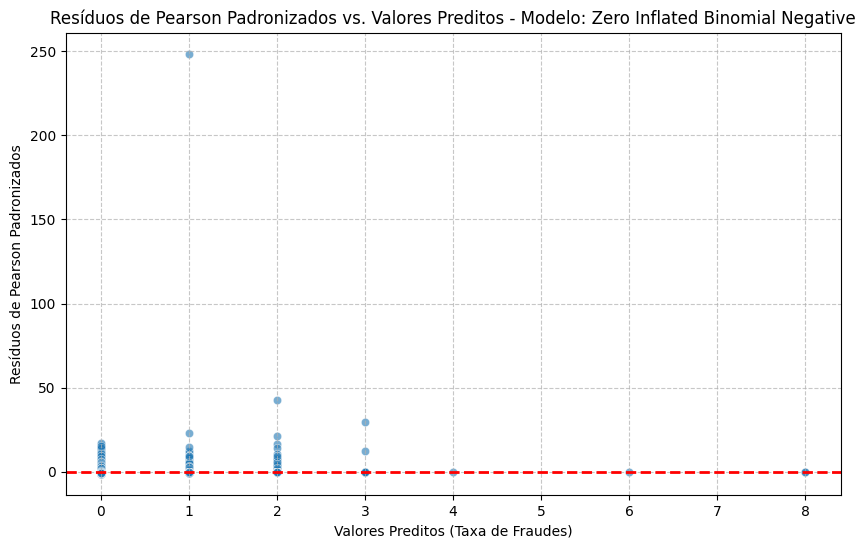

In [414]:
overdisp_plot(modelo_zinb_complete, 'Zero Inflated Binomial Negative')

In [415]:
df_features_zinp_complete = modelo_zinb_complete.pvalues.where(lambda x: x < 0.05).dropna().reset_index().rename(columns={'index':'Features', 0:'P-Value'})
feature_exog = list(filter(lambda x: x not in ['const', 'alpha'], df_features_zinp_complete.query('~Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas')
print(feature_exog)
feature_exog_inflate = list(filter(lambda x: x not in ['const', 'alpha'], df_features_zinp_complete.query('Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas Inflado')
print(feature_exog_inflate)

Exogenas
['total_amount', 'mean_amount', 'mean_num_credit_cards', 'use_chip_swipe_transaction', 'card_brand_mastercard', 'has_chip_yes', 'online_sales_no', 'category_arts_entertainment_recreation', 'category_food_beverage', 'category_government_utilities', 'category_retail_specialty', 'category_retail_home_garden', 'previous_frauds']
Exogenas Inflado
['total_amount', 'mean_current_age', 'mean_total_debt', 'mean_credit_limit', 'use_chip_swipe_transaction', 'card_type_debit_prepaid', 'has_chip_yes', 'online_sales_no', 'has_error_yes', 'category_arts_entertainment_recreation', 'category_food_beverage', 'category_government_utilities', 'category_retail_specialty', 'previous_frauds']


In [417]:
X1 = X_scaler[feature_exog].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[feature_exog_inflate].copy()
X2 = sm.add_constant(X2)

modelo_zinb_complete_filter = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='probit').fit(disp=False, cov_type='HC0')
modelo_zinb_complete_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                14363
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    14349
Method:                                      MLE   Df Model:                           13
Date:                           Mon, 02 Jun 2025   Pseudo R-squ.:                  0.1816
Time:                                   18:30:52   Log-Likelihood:                -12424.
converged:                                 False   LL-Null:                       -15182.
Covariance Type:                             HC0   LLR p-value:                     0.000
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
inflate_const                                      0.1232      0.058      2.114      0.035       0.009       0.237
inflate_total_amount                               0.1092      0.058      1.890      0.059      -0.004       0.222
inflate_mean_amount                                0.1168      0.078      1.499      0.134      -0.036       0.270
inflate_mean_num_credit_cards                     -0.1400      0.031     -4.459      0.000      -0.202      -0.078
inflate_use_chip_swipe_transaction                 0.2213      0.025      8.722      0.000       0.172       0.271
inflate_card_brand_mastercard                      0.0274      0.034      0.804      0.421      -0.039       0.094
inflate_has_chip_yes                              -0.0648      0.029     -2.235      0.025      -0.122      -0.008
inflate_online_sales_no                            0.1765      0.066      2.673      0.008       0.047       0.306
inflate_category_arts_entertainment_recreation     0.3564      0.044      8.135      0.000       0.271       0.442
inflate_category_food_beverage                    -0.1124      0.046     -2.442      0.015      -0.203      -0.022
inflate_category_government_utilities             -0.1156      0.050     -2.315      0.021      -0.213      -0.018
inflate_category_retail_specialty                 -0.3096      0.041     -7.583      0.000      -0.390      -0.230
inflate_category_retail_home_garden               -0.0330      0.034     -0.979      0.328      -0.099       0.033
inflate_previous_frauds                           -1.0590      0.043    -24.792      0.000      -1.143      -0.975
const                                              0.0427      0.047      0.903      0.367      -0.050       0.135
total_amount                                       1.1605      0.045     26.041      0.000       1.073       1.248
mean_amount                                       -0.4101      0.081     -5.045      0.000      -0.569      -0.251
mean_num_credit_cards                              0.1039      0.026      3.961      0.000       0.052       0.155
use_chip_swipe_transaction                         0.1129      0.021      5.372      0.000       0.072       0.154
card_brand_mastercard                              0.1210      0.025      4.821      0.000       0.072       0.170
has_chip_yes                                      -0.0572      0.024     -2.360      0.018      -0.105      -0.010
online_sales_no                                   -0.2262      0.039     -5.769      0.000      -0.303      -0.149
category_arts_entertainment_recreation             0.1284      0.034      3.731      0.000       0.061       0.196
category_food_beverage                             0.1289      0.037      3.464      0.001       0.056       0.202
category_government_utilities        

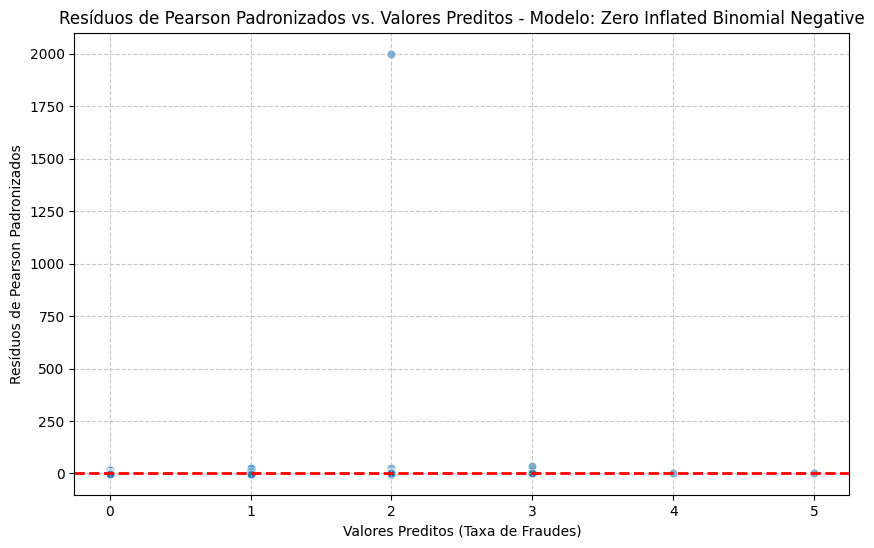

In [418]:
overdisp_plot(modelo_zinb_complete_filter, 'Zero Inflated Binomial Negative')

In [421]:
step_wise = StepwiseZeroInflated(alpha=0.05, model_type='ZINB', verbose=False, selection_criterion='AIC', model_params=dict(inflation='probit'), fit_params=dict(error='ignore', disp=False), batch_size=3, parallel_features=True)
step_wise.fit(X_scaler, y)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KeyboardInterrupt: 

In [ ]:
modelo_zinb_stepwise = step_wise.final_model_
modelo_zinb_stepwise.summary()

In [ ]:
overdisp_plot(modelo_zinb_stepwise, 'Zero Inflated Binomial Negative')

In [ ]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Completo Filter',
        'ZIP Stepwise',
        'ZINB Simples',
        'ZINB Completo',
        'ZINB Stepwise Completo Filter',
        'ZINB Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_complete_filter.llf,
        modelo_zip_stepwise.llf,
        modelo_zinb_simples.llf,
        modelo_zinb_complete.llf,
        modelo_zinb_complete_filter.llf,
        modelo_zinb_stepwise.llf
      ]
})

In [ ]:
titles = [
  'Poisson Simples',
  'Poisson Completo',
  'Poisson StepWise',
  'Binomial Simples',
  'Binomial Completo',
  'Binomial Stepwise',
  'ZIP Simples',
  'ZIP Completo',
  'ZIP Completo Filter',
  'ZIP Stepwise',
  'ZIMB Simples',
  'ZIMB Completo',
  'ZIMB Completo Filter',
  'ZIMB Stepwise',
]
models = [
    modelo_poison_simple,
    modelo_poison_complete,
    modelo_poisson_stepswise,
    modelo_binomialneg_simples,
    modelo_binomialneg_completo,
    modelo_binomialneg_stepwise,
    modelo_zip_simples,
    modelo_zip_complete,
    modelo_zip_complete_filter,
    modelo_zip_stepwise,
    modelo_zinb_simples,
    modelo_zinb_complete,
    modelo_zinb_complete_filter,
    modelo_zinb_stepwise
]

In [ ]:
metrics = []
for title, model in zip(titles, models):
  metric = dict(title=title, LLF=model.llf, BIC=model.bic, AIC=model.aic)

  if np.isnan(model.llf):
    continue

  if hasattr(model, 'prsquared'):
    metric['PseudoR2'] = model.prsquared
  else:
    metric['PseudoR2'] = model.pseudo_rsquared()

  metrics.append(metric)

In [ ]:
df_metrics = pd.DataFrame(metrics)
df_metrics.sort_values(by='AIC')

In [ ]:
plt.figure(figsize=(15,8))
plt.suptitle('Comparação de Modelos de Contagem')

plt.subplot(2,2,1)
plt.title('Métrica AIC dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(by=['AIC', 'title'], ascending=True), y='title', x='AIC')
plt.xlabel('$AIC$')
plt.ylabel('Modelos')

plt.subplot(2,2,2)
plt.title('Métrica BIC dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(['BIC', 'title'], ascending=True), y='title', x='BIC')
plt.xlabel('$BIC$')
plt.ylabel('Modelos')

plt.subplot(2,2,3)
plt.title('Métrica LLF dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(['LLF', 'title'], ascending=False), y='title', x='LLF')
plt.xlabel('$LLF$')
plt.ylabel('Modelos')

plt.subplot(2,2,4)
plt.title('Métrica Pseudo R2 dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(['PseudoR2', 'title'], ascending=False), y='title', x='PseudoR2')
plt.xlabel('$Pseudo R2$')
plt.ylabel('Modelos')

plt.tight_layout()
plt.show()

In [ ]:
metrics_titles = []
metrics_mse = []
metrics_rmse = []

In [ ]:
for title, model in zip(titles, models):

    if np.isnan(model.llf):
      continue

    metrics_titles.append(title)
    metrics_mse.append(mean_squared_error(y.loc[model.fittedvalues.index], round(model.fittedvalues)))
    metrics_rmse.append(root_mean_squared_error(y.loc[model.fittedvalues.index], round(model.fittedvalues)))

In [ ]:
plt.title('Metricas de performance')
sns.barplot(x=metrics_titles, y=metrics_mse, label='MSE')
sns.barplot(x=metrics_titles, y=metrics_rmse, label='RMSE')
plt.legend()
plt.grid()
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_predict_models = pd.concat([model.fittedvalues for model in models], axis=1)
df_predict_models.columns = titles

for column in df_predict_models.columns:
  df_predict_models[column] = df_predict_models[column].apply(lambda x: 0 if np.isnan(x) or int(round(x))< 0 else int(round(x)))

df_predict_models['Target'] = y
df_predict_models.head()

In [ ]:
df_resume = df_predict_models['Target'].value_counts().reset_index()
df_resume.columns = ['Target', 'Quantidade']
df_resume = df_resume.sort_values(by='Target').reset_index(drop=True)
df_resume.head()

In [ ]:
resumes = [df_resume]
for column in titles:
  df_resume = df_predict_models.assign(ok=lambda x: x['Target'] == x[column]).groupby('Target').agg({'ok':'sum'}).reset_index()
  df_resume.columns = ['Target', column]
  df_resume.drop(columns='Target', inplace=True)
  resumes.append(df_resume)
df_resume = pd.concat(resumes, axis=1)

In [ ]:
df_resume

In [ ]:
df_resume_percent = df_resume.copy()
for column in titles:
  df_resume_percent[column] = round(df_resume_percent[column] / df_resume_percent['Quantidade'], 2)
df_resume_percent

In [ ]:
df_resume_percent[titles].apply(lambda x: (len([xi for xi in x if xi > 0])/len(x)) * x.sum(), axis=0).sort_values(ascending=False)